#Föll

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_recall_fscore_support, ConfusionMatrixDisplay
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import time

def printarr(arr):
  row,col = np.shape(arr)
  print()
  for i in range(row):
    for j in range(col):
      print(arr[i,j], end = '   ')   
    print()
  print()
  return None

def printline():
  #print()
  for i in range(80):
    if i % 2 == 0:
      print('-', end='')
    else:
      print('+',end='')
  print()
  return None


def Show_Results(Model, X_ts, y_ts,y_fit = None,xG = None):
  if y_fit is None:
    y_fit = Model.predict(X_ts)
  if xG is None:
    xG = Model.predict_proba(X_ts)[:,1]
    tot_xG = np.sum(xG)
  elif xG is not None:
      tot_xG = np.sum(xG)

  tot_goals = np.sum(y_ts)
  acc_score = round(100*accuracy_score(y_ts,y_fit),3)
  conf_mat = confusion_matrix(y_ts,y_fit)
  printline()
  print(Model)
  printline()
  print('Classification report:')
  print()
  print(classification_report(y_ts,y_fit))
  printline()
  print('Confusion matrix:')
  print()
  printarr(conf_mat)
  printline()
  print('Accuracy score:',acc_score,'%')
  print()
  printline()
  print('Total goals in test data:    ',tot_goals)
  print('Summed expected goals:       ',tot_xG)
  print('RMSE á test gögnum           ',mean_squared_error(y_test,xG, squared=True))
  printline()

def MyScaler(X):
  rows, cols = np.shape(X)
  Transform_BP = {1 : -1, 2 : 0, 3 : 1}
  Transform_AM = {0 : -1, 1 : -0.5, 2 : 0, 3 : 0.5, 4 : 1}
  Transform_S =  {1 : -1, 2 : -1/3, 3 : 1/3, 4 : 1/3}
  Transform_FB = {0 : -1, 1 : 1}
  Transform_LOC = {}
  bil  = np.linspace(-1,1,18)
  for i in range(1,len(bil)+1):
    Transform_LOC[i] = bil[i-1]
  
  Transformers = {0 : Transform_LOC, 1 : Transform_BP, 2 : Transform_AM,
                  3 : Transform_S, 4 : Transform_FB}
  for j in range(cols):
    transformer = Transformers[j]
    for i in range(rows):
      X[i,j] = transformer[X[i,j]]
  return X

def GetCountry(data, country_name):
  return data[data.country == country_name]

def GetYear(data,year):
  return data[data.season == year]
def GetLoc(data,loc_int):
  return data[data.location == loc_int] 


def GetDataWithDummies(data):
  new = data.iloc[:,-8:-3]
  cols = ['location', 'bodypart','assist_method', 'situation']
  data_w_dummies = pd.get_dummies(new, columns = cols).reset_index(drop=True)
  data_w_dummies.columns  = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
  return data_w_dummies
  

def EvaluateModel(name):
  #cols = ['location', 'bodypart', 'assist_method', 'situation', 'fast_break','Log_Reg_xG','RF_xG','NN_1_xG', 'GBC_xG']
  best2worst_shots = shots.copy()
  #droppum duplicate línum (fyrir skot samsetningu)
  best2worst_shots.drop_duplicates(subset = ['location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
                                   keep='first',inplace=True)
  show = best2worst_shots.sort_values(by = name, ascending=False).reset_index(drop=True)
  plt.close("all")
  xG = show[name]
  plt.figure(figsize=(15,5))
  xG.plot(x = 'index', y = name)
  plt.grid()
  plt.xlabel('tegundir skota',fontsize=16)
  plt.ylabel('xG',fontsize=16)
  plt.title('xG fyrir hverja samsetningu skots', fontsize=24)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend(['xG fyrir hverja samsetningu af skoti'])
  plt.show()
  printline()

  show = shots.sort_values(by = name, ascending=False)
  plt.close("all")
  plt.figure(figsize=(15,5))
  show[name].hist(stacked=True,bins =10)
  plt.ylabel('Fjöldi skota',fontsize = 16)
  plt.xlabel('xG',fontsize=16)
  plt.title('Fjöldi skota í gagnasetti með tiltekið xG', fontsize = 24)
  plt.xticks(np.arange(0,1.1,0.1))
  plt.show()
  printline()


  plt.close("all")
  plt.figure(figsize=(15,5))
  show[name].hist(stacked=True,bins =10)
  plt.ylabel('Fjöldi skota',fontsize=16)
  plt.xlabel('xG',fontsize=16)
  plt.title('Fjöldi skota í gagnasetti með xG > 0.5', fontsize = 24)
  plt.xticks(np.arange(0,1.1,0.1))
  plt.ylim([0,5000])
  plt.xlim([0.5,1])
  plt.show()

def PlotxGMinusRealGoals(model,model_name):
  model_ratio = model + '_hlutfall'
  model_diff = model + '_mismunur'
  model_xG = model + '_xG'
  print(model_name)
  printline()
  print('Meðal hlutfall (mörk/xG):            ',np.round(players[model_ratio].mean(),4))
  print('Meðal mismunur marka og xG (xG-mörk) ',np.round(players[model_diff].mean(),4))
  print('Fjöldi marka í gagnasettinu:                     ',players['total_goals'].sum())
  print('Fjöldi spáðra marka (heildar xG) í gagnasettinu: ',np.round(players[model_xG].sum(),4))
  printline()
  plt.figure(figsize=(8,6))
  players[model_diff].hist(stacked=True,bins =200)
  plt.xlim((-20,20))
  plt.title('Tíðnirit yfir mismun xG og raunverulegra marka')
  plt.xlabel('Tot_xG - Raunveruleg mörk')
  plt.show()

def DisplayByFeature(model,feature_inp,nr,goals_over = None):
  feature = model+feature_inp
  xG = model + '_xG'
  mismunur = model + '_mismunur'
  hlutfall = model + '_hlutfall'
  asc = False
  if feature_inp == '_hlutfall' and goals_over is not None:
    show = players[players.total_goals > goals_over].sort_values(by = feature ,ascending=asc).reset_index(drop=True)
    return show[['player','total_goals', xG, mismunur, hlutfall]].head(nr)
  elif feature_inp == '_hlutfall' and goals_over is None:
    print('Must give goals_over')
    return None
  if feature_inp == '_mismunur':
    asc = True
    show = players.sort_values(by = feature ,ascending=asc).reset_index(drop=True)
    return show[['player','total_goals', xG, mismunur, hlutfall]].head(nr)
  show = players.sort_values(by = feature ,ascending=asc).reset_index(drop=True)
  return show[['player','total_goals', xG, mismunur, hlutfall]].head(nr)

def train_and_evaluate(Model,X_tr,X_ts,y_tr,y_ts,Model_name):
  global players
  global shots
  xG = Model_name + '_xG'
  mismunur = Model_name + '_mismunur' 
  hlutfall = Model_name + '_hlutfall'

  Model.fit(X_tr,y_tr)
  scores = cross_validate(Model, X_tr,y_tr,
                          scoring = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'],
                          cv = 5)
  score = pd.DataFrame.from_dict(scores, orient='index')
  printline()
  print('Cross validation results:')
  print()
  for key in scores.keys():
   print('Mean cross val score:',key,':  ',round(np.mean(scores[key]),3))
  printline()
  Show_Results(Model,X_test,y_test)
  #-----------------------------------------------------------------------------
  #Bætum Log Reg xG við í gagnasettið
  #-----------------------------------------------------------------------------
  shots[xG] = Model.predict_proba(X_full)[:,1]
  shots[mismunur] = round(shots[xG] - shots['is_goal'],3)
  group = shots[['player', xG, mismunur]].groupby(by = 'player', as_index = False).sum().reset_index()
  players = players.merge(group[['player', xG, mismunur]],
                      on = 'player',
                      how = 'left')
  players[hlutfall] = round(players['total_goals'] / players[xG],3)
  PlotxGMinusRealGoals(model = Model_name, model_name = Model_name)
  EvaluateModel(xG)
  return score


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_colwidth", -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


#Gagnabrask

In [3]:
#Sækjum gögnin
from google.colab import drive
drive.mount('/content/drive')
events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/events.csv')
info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/ginf.csv')
                  

Mounted at /content/drive


In [4]:
#Skoðum hvað er í events.csv
events_row, events_col = np.shape(events)
printline()
print('Fjöldi lína í gagnasettinu events.csv:', events_row)
print('Fjöldi dálka í gagnasettinu events.csv:', events_col)
printline()
print('Dálkar og tög þeirra í events:')
print()
print(events.dtypes)
printline()



-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi lína í gagnasettinu events.csv: 941009
Fjöldi dálka í gagnasettinu events.csv: 22
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Dálkar og tög þeirra í events:

id_odsp          object 
id_event         object 
sort_order       int64  
time             int64  
text             object 
event_type       int64  
event_type2      float64
side             int64  
event_team       object 
opponent         object 
player           object 
player2          object 
player_in        object 
player_out       object 
shot_place       float64
shot_outcome     float64
is_goal          int64  
location         float64
bodypart         float64
assist_method    int64  
situation        float64
fast_break       int64  
dtype: object
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [5]:
#Skoðum hvað er í info.csv
info_row, info_col = np.shape(info)
info_row, info_col = np.shape(info)
printline()
print('Fjöldi lína í gagnasettinu ginf.csv:', info_row)
print('Fjöldi dálka í gagnasettinu ginf.csv:', info_col)
printline()
print('Dálkar og tög í info')
print(info.dtypes)

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi lína í gagnasettinu ginf.csv: 10112
Fjöldi dálka í gagnasettinu ginf.csv: 18
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Dálkar og tög í info
id_odsp      object 
link_odsp    object 
adv_stats    bool   
date         object 
league       object 
season       int64  
country      object 
ht           object 
at           object 
fthg         int64  
ftag         int64  
odd_h        float64
odd_d        float64
odd_a        float64
odd_over     float64
odd_under    float64
odd_bts      float64
odd_bts_n    float64
dtype: object


In [6]:
#Lýtum á nokkrar línur í gagnasettinu info
info.iloc[:1]

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-hamburger-UFot0hit/,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


In [7]:
#Lýtum á nokkrar línur í gagnasettinu events
events.iloc[:1]

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left footed shot from the left side of the box is high and wide to the left. Assisted by Gokhan Tore.,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0


In [8]:
#Hversu margir leikir eru í gagnasettinu, dreyfing milli ára og deilda
pd.crosstab(info.country,info.season)

season,2012,2013,2014,2015,2016,2017
country,,,,,,
england,380,380,380,380,380,220
france,380,380,379,380,380,208
germany,306,308,308,307,308,153
italy,380,379,380,380,380,207
spain,380,380,380,380,380,189


In [9]:
#-------------------------------------------------------------------------------
#Viljum joina gagnasettin events og info á 'id_odsp'  sem er "unique identifier 
#of game" skv. skilgreinignu á gagnasettinu. Fáum inn land og dagsetningu í 
#events.
#-------------------------------------------------------------------------------
events = events.merge(info[['id_odsp', 'country', 'date', 'season']],
                      on = 'id_odsp',
                      how = 'left')


##Shots
**ATH**

Hér hendi ég út nokkrum línum sem ekki innihalda fullnægjandi gögn fyrir *xG* módelið, þetta geri ég til að módelið virki sem best, en verður til þess að einhver skot og mörk munu hverfa úr gagnasettinu. Heildar markafjöldi leikmanna, liða o.frv. í greiningu er því aðeins skertur. 

In [10]:
#Viljum búa til gagnasett sem inniheldur aðeins upplýsingar um skot.
#'event_type' == 1 auðkennir attempt/skot.
#Hendum út línum sem hafa Nan gildi í einhverjum af dálkum sem nefndir eru í 
#fyrri cols listanum.
#Hendum út línum með 'location' == 19 þ.e Not recorded.

shots = events[events['event_type'] == 1]
cols = ['shot_place', 'shot_outcome', 'is_goal', 'location', 'bodypart',
        'assist_method', 'situation', 'fast_break']

shots = shots.dropna(subset=cols, how= 'any')
shots = shots[shots['location'] != 19]
cols = ['shot_place', 'shot_outcome', 'location', 'bodypart', 'situation']
shots[cols] = shots[cols].astype('int64')
shots_row, shots_col = np.shape(shots)
printline()
print('Fjöldi skota í shots:', shots_row)
print()
print('Dálkar í shots og tög dálka:')
print()
print(shots.dtypes)
printline()

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi skota í shots: 226677

Dálkar í shots og tög dálka:

id_odsp          object 
id_event         object 
sort_order       int64  
time             int64  
text             object 
event_type       int64  
event_type2      float64
side             int64  
event_team       object 
opponent         object 
player           object 
player2          object 
player_in        object 
player_out       object 
shot_place       int64  
shot_outcome     int64  
is_goal          int64  
location         int64  
bodypart         int64  
assist_method    int64  
situation        int64  
fast_break       int64  
country          object 
date             object 
season           int64  
dtype: object
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [11]:
#-------------------------------------------------------------------------------
#Hér er ég að laga tögin svo ég geti leitað af leikmönnum og liðum eftir heiti
#með að leita að streng
#-------------------------------------------------------------------------------
shots['event_team'] = shots['event_team'].str.title()
shots['player'] = shots['player'].str.title()
shots['country'] = shots['country'].str.title()
shots['player2'] = shots['player2'].str.title()

#Skoðum línur í shots
shots.iloc[999:1000]

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,season
4387,0vWe9vtS/,0vWe9vtS22,22,19,"Goal! 1. FC Koln 1, Kaiserslautern 1. Mato Jajalo (1. FC Koln) right footed shot from the centre of the box to the bottom left corner.",1,NaN,1,Fc Cologne,Kaiserslautern,Mato Jajalo,NaN,NaN,NaN,3,1,1,3,1,0,1,0,Germany,2011-08-20,2012


##Players

In [12]:
cols = ['player', 'is_goal']
players = shots[cols].groupby('player').sum().reset_index()
players.rename(columns= {'is_goal' : 'total_goals'},inplace=True)

##Hvað leynist í þessum gögnum???

In [13]:
new = GetDataWithDummies(shots)
newnew = new[new.penalty == 1]
newnew.head(1)


,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,penalty,outside_box,long_range,more_35y,more_40y,right_foot,left_foot,header,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick
338,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


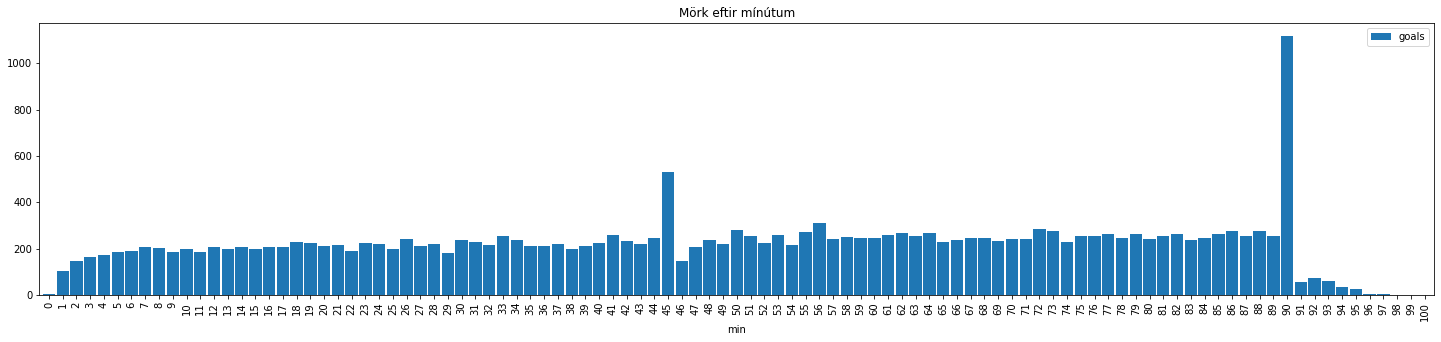

In [14]:
#-------------------------------------------------------------------------------
#Mörk eftir mínútum
#-------------------------------------------------------------------------------
show = shots.groupby(by = 'time', as_index= False).sum().rename(columns = {'is_goal' : 'goals', 'time' : 'min'})
show.plot.bar(x = 'min', y = 'goals', width=0.9, title = 'Mörk eftir mínútum',figsize=(25,5,) )


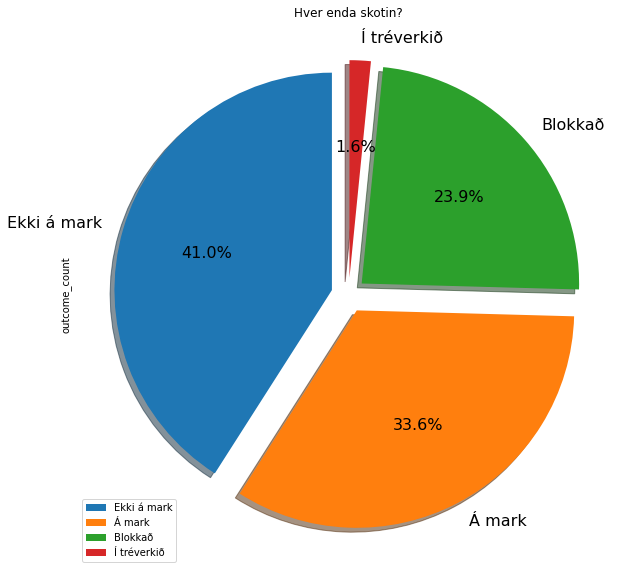

In [15]:
show = shots[['shot_outcome', 'id_event']].groupby(by = 'shot_outcome').count().reset_index().rename(columns = {'id_event' : 'outcome_count' })
show = show.sort_values(by='outcome_count',ascending=False)
show['shot_outcome'] = show['shot_outcome'].replace({1 :	"Á mark", 2 :	"Ekki á mark", 3	: "Blokkað", 4	: "Í tréverkið"})
explode = [0.08]*4
show.plot.pie(y='outcome_count', labels=show['shot_outcome'],figsize=(10,10), autopct='%1.1f%%',fontsize=16,title='Hver enda skotin?', explode=explode, shadow = True, startangle = 90)

<function matplotlib.pyplot.show>

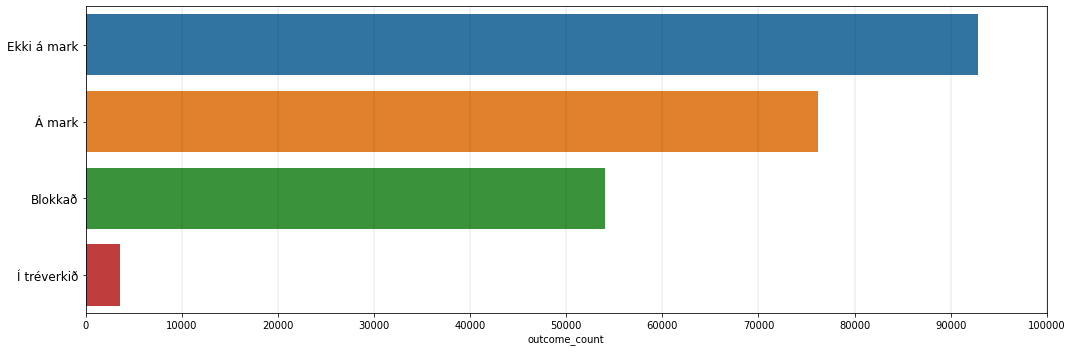

In [16]:
fig,ax = plt.subplots(figsize = (15,5))
label = show['shot_outcome']
ax = sn.barplot(x=show['outcome_count'],y=show['shot_outcome'])
ax.set_yticklabels(label,size=12)
ax.set_ylabel(ylabel='')
ax.grid(color = 'black', linestyle='-', linewidth=0.1, axis='x')
ax.set_xticks(np.linspace(0,100000,11))
plt.tight_layout()
plt.show

<Figure size 432x288 with 0 Axes>

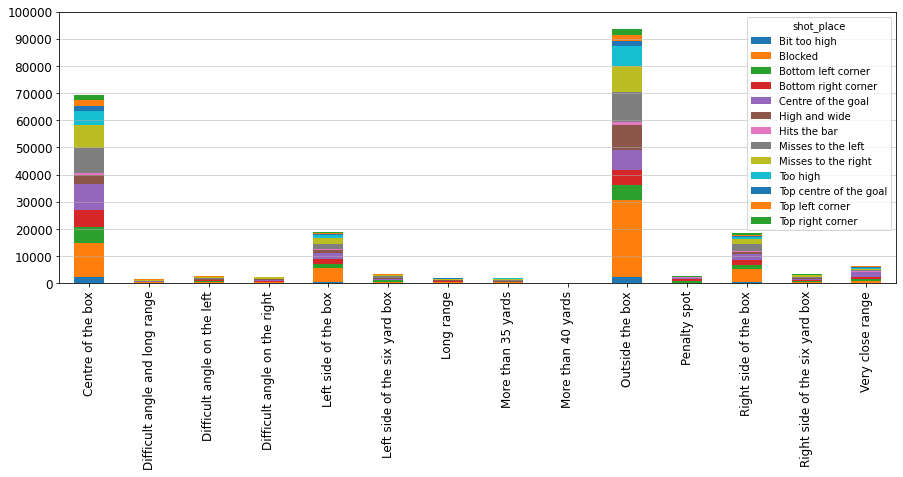

In [17]:
show = shots[['shot_place', 'location']].astype('int64')
show['shot_place'] = show['shot_place'].replace({1:	"Bit too high", 2 : "Blocked", 3 : "Bottom left corner", 4 : "Bottom right corner", 5 : "Centre of the goal",
                                                   6 :	"High and wide", 7 :	"Hits the bar", 8 :	"Misses to the left", 9 :	"Misses to the right", 10	: "Too high",
                                                   11 : "Top centre of the goal", 12	: "Top left corner",  13	: "Top right corner"})
show['location'] = show['location'].replace({1:	"Attacking half",2	: "Defensive half", 3:	"Centre of the box",4:	"Left wing",5:	"Right wing",6:"Difficult angle and long range",
                                             7:	"Difficult angle on the left",8:	"Difficult angle on the right",9:	"Left side of the box",10:	"Left side of the six yard box",
                                             11:	"Right side of the box",12:	"Right side of the six yard box",13:	"Very close range",14:	"Penalty spot",15:	"Outside the box",

                                             16:	"Long range",17:	"More than 35 yards",18:	"More than 40 yards"})
a = pd.crosstab(show.location,show.shot_place)
plt.figure()
a.plot.bar(stacked=True,fontsize=12,figsize=(15,5))
plt.yticks(ticks = np.linspace(0,100000,11))
plt.grid(axis='y', linestyle = '-' , linewidth = 0.5)
plt.xlabel('')
plt.show()


<Figure size 432x288 with 0 Axes>

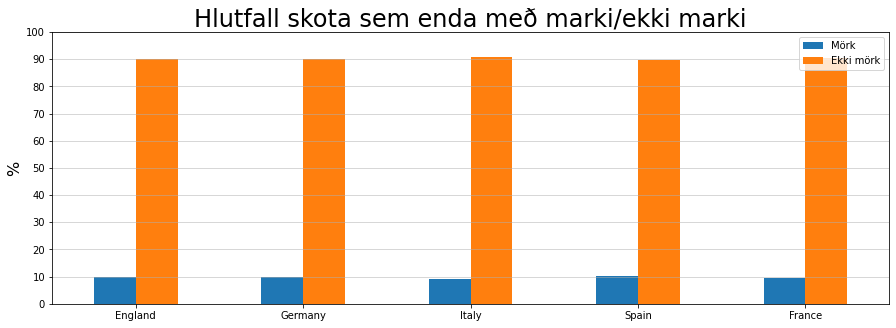

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi skota eftir landi

England : Fjöldi skota: 33665 || Fjöldi marka: 3305 || Hlutfall: 9.817 %
Germany : Fjöldi skota: 41038 || Fjöldi marka: 4122 || Hlutfall: 10.044 %
Italy : Fjöldi skota: 54163 || Fjöldi marka: 4919 || Hlutfall: 9.082 %
Spain : Fjöldi skota: 49409 || Fjöldi marka: 5039 || Hlutfall: 10.199 %
France : Fjöldi skota: 48402 || Fjöldi marka: 4610 || Hlutfall: 9.524 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [18]:
Country = {}
row = {}
col = {}
goals = {}
countries  = ['England', 'Germany', 'Italy', 'Spain', 'France']
for country in countries:
  Country[country] = GetCountry(shots,country)
  row[country], col[country] = np.shape(Country[country]) 
  goals[country] = Country[country].is_goal.sum()

show = pd.DataFrame({'Nr_shots' : [row[country] for country in countries],
                     'Nr_goals' : [goals[country] for country in countries]},
                     index = countries)

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 

fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_title('Hlutfall skota sem enda með marki/ekki marki', fontsize =24)
plt.show()

printline()
print('Fjöldi skota eftir landi')
print()
for country in countries:
  print(country,': Fjöldi skota:',row[country],'|| Fjöldi marka:',goals[country],'|| Hlutfall:',round(100*goals[country]/row[country],3),'%',)
printline()

<Figure size 432x288 with 0 Axes>

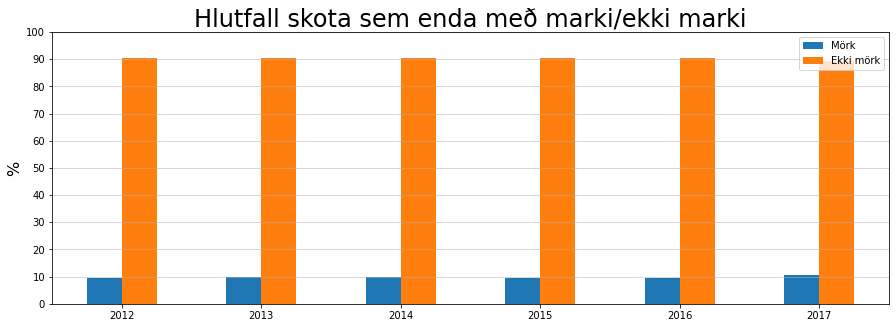

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi eftir árum

2012 : Fjöldi skota: 34941 || Fjöldi marka: 3279 || Hlutfall: 9.384 %
2013 : Fjöldi skota: 36140 || Fjöldi marka: 3510 || Hlutfall: 9.712 %
2014 : Fjöldi skota: 44080 || Fjöldi marka: 4286 || Hlutfall: 9.723 %
2015 : Fjöldi skota: 43750 || Fjöldi marka: 4175 || Hlutfall: 9.543 %
2016 : Fjöldi skota: 43666 || Fjöldi marka: 4217 || Hlutfall: 9.657 %
2017 : Fjöldi skota: 24100 || Fjöldi marka: 2528 || Hlutfall: 10.49 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [19]:
Year = {}
row = {}
col = {}
goals = {}
years = [2012,2013,2014,2015,2016,2017]
for year in years:
  Year[year] = GetYear(shots,year)
  row[year], col[year] = np.shape(Year[year])
  goals[year] = Year[year].is_goal.sum()

show = pd.DataFrame({'Nr_shots' : [row[year] for year in years],
                     'Nr_goals' : [goals[year] for year in years]},
                     index = years)

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 

fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_title('Hlutfall skota sem enda með marki/ekki marki', fontsize =24)
plt.show()

printline()
print('Fjöldi eftir árum')
print()
for year in years:
  print(year,': Fjöldi skota:',row[year],'|| Fjöldi marka:',goals[year],'|| Hlutfall:',round(100*goals[year]/row[year],3),'%',)
printline()

<Figure size 432x288 with 0 Axes>

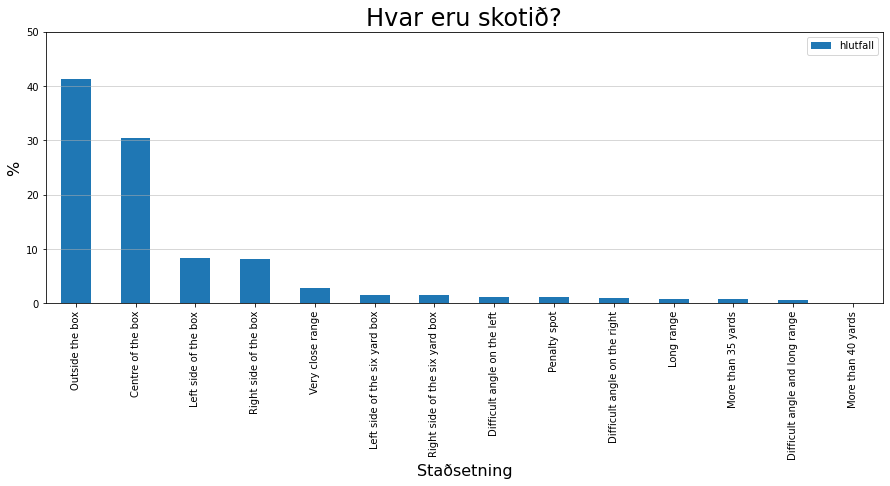

,location,loc_count,hlutfall
0,Centre of the box,69162,30.511
1,Difficult angle and long range,1513,0.667
2,Difficult angle on the left,2555,1.127
3,Difficult angle on the right,2447,1.080
4,Left side of the box,19000,8.382
5,Left side of the six yard box,3459,1.526
6,Right side of the box,18396,8.116
7,Right side of the six yard box,3388,1.495
8,Very close range,6421,2.833
9,Penalty spot,2506,1.106


In [20]:
#-------------------------------------------------------------------------------
#Hvar er skotið
#-------------------------------------------------------------------------------

        
show = shots[['location', 'id_event']].groupby(by = 'location').count().reset_index().rename(columns = {'id_event' : 'loc_count' })
show['location'] = show['location'].replace({1:	"Attacking half",2	: "Defensive half", 3:	"Centre of the box",4:	"Left wing",5:	"Right wing",6:"Difficult angle and long range",
                                             7:	"Difficult angle on the left",8:	"Difficult angle on the right",9:	"Left side of the box",10:	"Left side of the six yard box",
                                             11:	"Right side of the box",12:	"Right side of the six yard box",13:	"Very close range",14:	"Penalty spot",15:	"Outside the box",
                                             16:	"Long range",17:	"More than 35 yards",18:	"More than 40 yards"})


sum = show.loc_count.sum()
show['hlutfall'] = round(100 * show.loc_count / sum , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'location', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Staðsetning',fontsize = 16)
ax.set_title('Hvar eru skotið?', fontsize =24)
plt.show()
show

<Figure size 432x288 with 0 Axes>

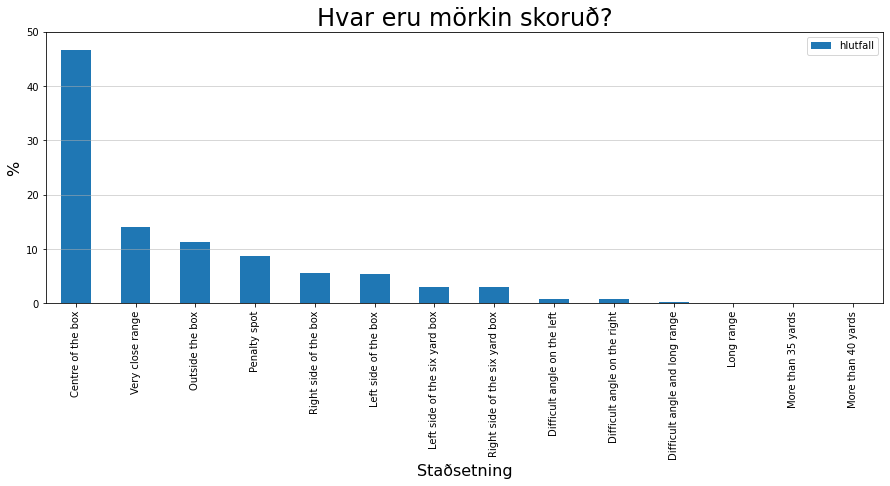

,location,loc_count,hlutfall
0,Centre of the box,10269,46.688
1,Difficult angle and long range,39,0.177
2,Difficult angle on the left,193,0.877
3,Difficult angle on the right,176,0.800
4,Left side of the box,1201,5.460
5,Left side of the six yard box,678,3.083
6,Right side of the box,1228,5.583
7,Right side of the six yard box,664,3.019
8,Very close range,3097,14.080
9,Penalty spot,1899,8.634


In [21]:
#-------------------------------------------------------------------------------
#Ætla að búa til gagnasett sem inniheldur bara mörk
#-------------------------------------------------------------------------------
goals = shots[(shots['is_goal'] == 1)]
        
show = goals[['location', 'id_event']].groupby(by = 'location').count().reset_index().rename(columns = {'id_event' : 'loc_count' })
show['location'] = show['location'].replace({1:	"Attacking half",2	: "Defensive half", 3:	"Centre of the box",4:	"Left wing",5:	"Right wing",6:"Difficult angle and long range",
                                             7:	"Difficult angle on the left",8:	"Difficult angle on the right",9:	"Left side of the box",10:	"Left side of the six yard box",
                                             11:	"Right side of the box",12:	"Right side of the six yard box",13:	"Very close range",14:	"Penalty spot",15:	"Outside the box",
                                             16:	"Long range",17:	"More than 35 yards",18:	"More than 40 yards"})

tot_goals = show.loc_count.sum()
show['hlutfall'] = round(100 * show.loc_count / tot_goals , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'location', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Staðsetning',fontsize = 16)
ax.set_title('Hvar eru mörkin skoruð?', fontsize =24)
plt.show()
show

<Figure size 432x288 with 0 Axes>

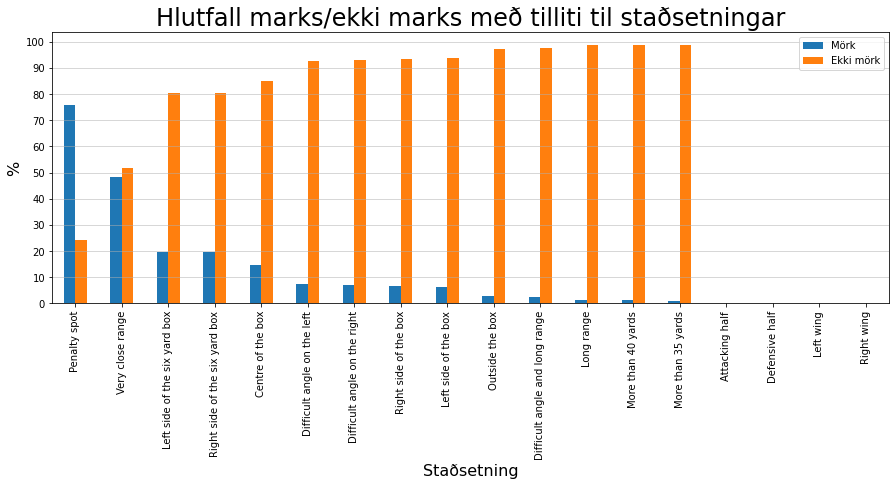

,Nr_shots,Nr_goals,%goals,%not_goal
Penalty spot,2506,1899,75.778,24.222
Very close range,6421,3097,48.232,51.768
Left side of the six yard box,3459,678,19.601,80.399
Right side of the six yard box,3388,664,19.599,80.401
Centre of the box,69162,10269,14.848,85.152
Difficult angle on the left,2555,193,7.554,92.446
Difficult angle on the right,2447,176,7.192,92.808
Right side of the box,18396,1228,6.675,93.325
Left side of the box,19000,1201,6.321,93.679
Outside the box,93610,2498,2.669,97.331


In [22]:
Loc = {}
row = {}
col = {}
goals = {}
locs = [i for i in range(1,19)]
for loc in locs:
  Loc[loc] = GetLoc(shots,loc)
  row[loc], col[loc] = np.shape(Loc[loc])
  goals[loc] = Loc[loc].is_goal.sum()

transformer = {1:	"Attacking half",2	: "Defensive half", 3:	"Centre of the box",4:	"Left wing",5:	"Right wing",6:"Difficult angle and long range",
               7:	"Difficult angle on the left",8:	"Difficult angle on the right",9:	"Left side of the box",10:	"Left side of the six yard box",
               11:	"Right side of the box",12:	"Right side of the six yard box",13:	"Very close range",14:	"Penalty spot",15:	"Outside the box",
               16:	"Long range",17:	"More than 35 yards",18:	"More than 40 yards"}

show = pd.DataFrame({'Nr_shots' : [row[loc] for loc in locs],
                     'Nr_goals' : [goals[loc] for loc in locs]},
                     index = [transformer[i] for i in range(1,19)])

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 
show = show.sort_values(by = '%goals', ascending=False)
fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
plt.xticks(rotation=90)
ax.set_xlabel('Staðsetning',fontsize = 16)
ax.set_title('Hlutfall marks/ekki marks með tilliti til staðsetningar', fontsize =24)
plt.show()
show



<Figure size 432x288 with 0 Axes>

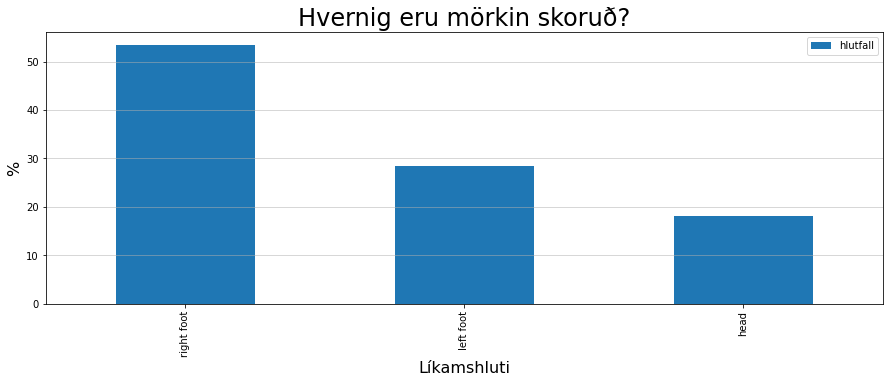

In [23]:
goals = shots[shots.is_goal == 1]
show = goals[['bodypart', 'id_event']].groupby(by = 'bodypart').count().reset_index().rename(columns = {'id_event' : 'bp_count' })
show['bodypart'] = show['bodypart'].replace({1	: "right foot", 2: "left foot", 3:	"head"})

tot_goals = show.bp_count.sum()
show['hlutfall'] = round(100 * show.bp_count / tot_goals , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'bodypart', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Líkamshluti',fontsize = 16)
ax.set_title('Hvernig eru mörkin skoruð?', fontsize =24)
plt.show()

<Figure size 432x288 with 0 Axes>

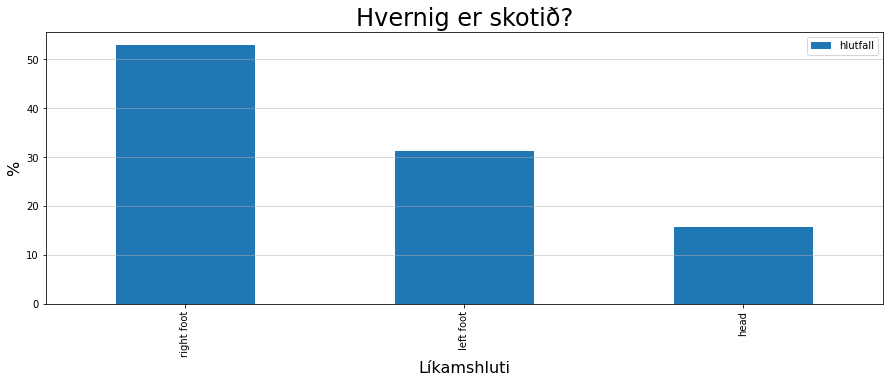

In [24]:
show = shots[['bodypart', 'id_event']].groupby(by = 'bodypart').count().reset_index().rename(columns = {'id_event' : 'bp_count' })
show['bodypart'] = show['bodypart'].replace({1	: "right foot", 2: "left foot", 3:	"head"})

tot = show.bp_count.sum()
show['hlutfall'] = round(100 * show.bp_count / tot , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'bodypart', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Líkamshluti',fontsize = 16)
ax.set_title('Hvernig er skotið?', fontsize =24)
plt.show()

<Figure size 432x288 with 0 Axes>

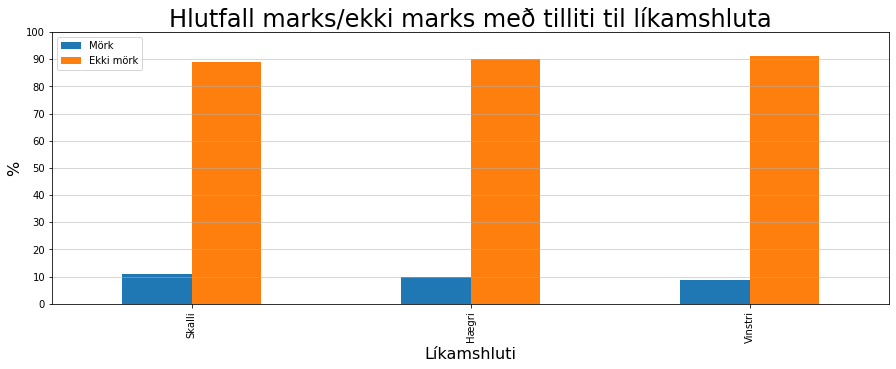

,Nr_shots,Nr_goals,%goals,%not_goal
Skalli,35697,3977,11.141,88.859
Hægri,120203,11762,9.785,90.215
Vinstri,70777,6256,8.839,91.161


In [25]:
def GetBodypart(data,bp_int):
  return data[data.bodypart == bp_int]

BP = {}
row = {}
col = {}
goals = {}
bps = [i for i in range(1,4)]
for bp in bps:
  BP[bp] = GetBodypart(shots,bp)
  row[bp], col[bp] = np.shape(BP[bp])
  goals[bp] = BP[bp].is_goal.sum()

transformer = {1:	"Hægri",2	: "Vinstri", 3:	"Skalli"}

show = pd.DataFrame({'Nr_shots' : [row[bp] for bp in bps],
                     'Nr_goals' : [goals[bp] for bp in bps]},
                     index = [transformer[i] for i in range(1,4)])

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 
show = show.sort_values(by = '%goals', ascending=False)
fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
plt.xticks(rotation=90)
ax.set_xlabel('Líkamshluti',fontsize = 16)
ax.set_title('Hlutfall marks/ekki marks með tilliti til líkamshluta', fontsize =24)
plt.show()
show



<Figure size 432x288 with 0 Axes>

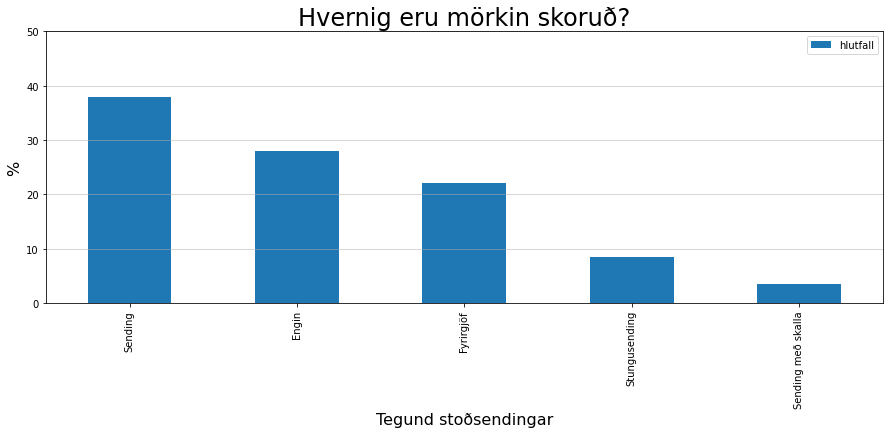

In [26]:
goals = shots[shots.is_goal ==1]
show = goals[['assist_method', 'id_event']].groupby(by = 'assist_method').count().reset_index().rename(columns = {'id_event' : 'as_count' })
show['assist_method'] = show['assist_method'].replace({0 :	"Engin", 1:	"Sending", 2:	"Fyrirgjöf", 3:	"Sending með skalla", 4:	"Stungusending"})

tot_goals = show.as_count.sum()
show['hlutfall'] = round(100 * show.as_count / tot_goals , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'assist_method', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Tegund stoðsendingar',fontsize = 16)
ax.set_title('Hvernig eru mörkin skoruð?', fontsize =24)
plt.show()

<Figure size 432x288 with 0 Axes>

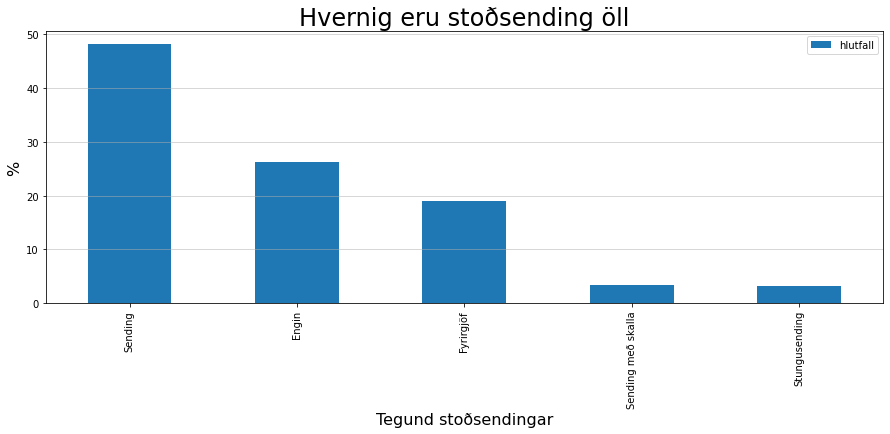

In [27]:
show = shots[['assist_method', 'id_event']].groupby(by = 'assist_method').count().reset_index().rename(columns = {'id_event' : 'as_count' })
show['assist_method'] = show['assist_method'].replace({0 :	"Engin", 1:	"Sending", 2:	"Fyrirgjöf", 3:	"Sending með skalla", 4:	"Stungusending"})

tot_goals = show.as_count.sum()
show['hlutfall'] = round(100 * show.as_count / tot_goals , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'assist_method', figsize = (15,5))
ax.set_yticks(np.linspace(0,50,6))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Tegund stoðsendingar',fontsize = 16)
ax.set_title('Hvernig eru stoðsending öll', fontsize =24)
plt.show()

<Figure size 432x288 with 0 Axes>

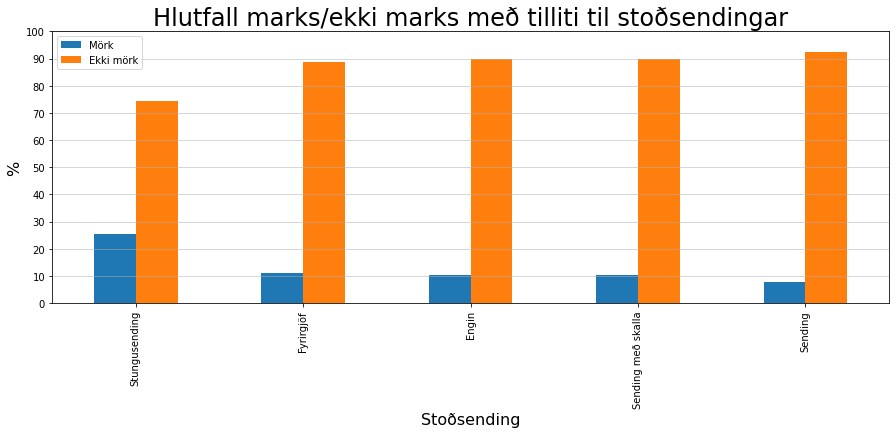

,Nr_shots,Nr_goals,%goals,%not_goal
Stungusending,7313,1861,25.448,74.552
Fyrirgjöf,42978,4848,11.280,88.720
Engin,59536,6148,10.327,89.673
Sending með skalla,7659,790,10.315,89.685
Sending,109191,8348,7.645,92.355


In [28]:
def GetAssist(data,as_met_int):
  return data[data.assist_method == as_met_int]

AS_MET = {}
row = {}
col = {}
goals = {}
as_mets = [i for i in range(5)]
for as_met in as_mets:
  AS_MET[as_met] = GetAssist(shots,as_met)
  row[as_met], col[as_met] = np.shape(AS_MET[as_met])
  goals[as_met] = AS_MET[as_met].is_goal.sum()

transformer = {0:	"Engin",1	: "Sending", 2:	"Fyrirgjöf", 3: "Sending með skalla", 4: "Stungusending" }

show = pd.DataFrame({'Nr_shots' : [row[i] for i in as_mets],
                     'Nr_goals' : [goals[i] for i in as_mets]},
                     index = [transformer[i] for i in range(5)])

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 
show = show.sort_values(by = '%goals', ascending=False)
fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
plt.xticks(rotation=90)
ax.set_xlabel('Stoðsending',fontsize = 16)
ax.set_title('Hlutfall marks/ekki marks með tilliti til stoðsendingar', fontsize =24)
plt.show()
show



<Figure size 432x288 with 0 Axes>

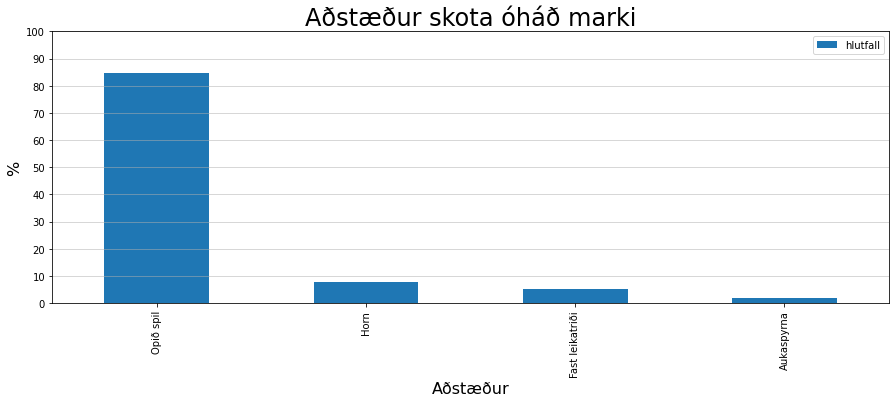

In [29]:
goals = shots[shots.is_goal == 1]
show = shots[['situation', 'id_event']].groupby(by = 'situation').count().reset_index().rename(columns = {'id_event' : 'count' })
show['situation'] = show['situation'].replace({1	: "Opið spil", 2:	"Fast leikatriði", 3: "Horn", 4: "Aukaspyrna" })

tot = show['count'].sum()
show['hlutfall'] = round(100 * show['count'] / tot , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'situation', figsize = (15,5))
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Aðstæður',fontsize = 16)
ax.set_title('Aðstæður skota óháð marki', fontsize =24)
plt.show()

<Figure size 432x288 with 0 Axes>

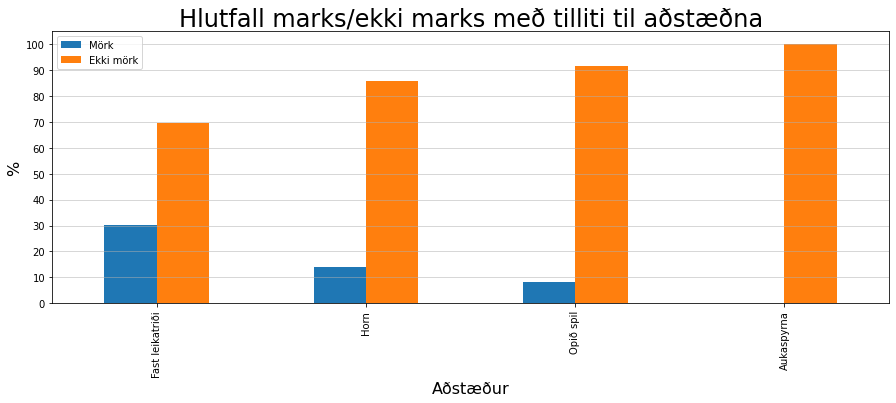

,Nr_shots,Nr_goals,%goals,%not_goal
Fast leikatriði,11567,3497,30.233,69.767
Horn,18046,2546,14.108,85.892
Opið spil,192379,15952,8.292,91.708
Aukaspyrna,4685,0,0.000,100.000


In [30]:
def GetSituation(data,situ_int):
  return data[data.situation == situ_int]

Situation = {}
row = {}
col = {}
goals = {}
situations = [i for i in range(1,5)]
for i in situations:
  Situation[i] = GetSituation(shots,i)
  row[i], col[i] = np.shape(Situation[i])
  goals[i] = Situation[i].is_goal.sum()

transformer = {1	: "Opið spil", 2:	"Fast leikatriði", 3: "Horn", 4: "Aukaspyrna" }

show = pd.DataFrame({'Nr_shots' : [row[i] for i in situations],
                     'Nr_goals' : [goals[i] for i in situations]},
                     index = [transformer[i] for i in range(1,5)])

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 
show = show.sort_values(by = '%goals', ascending=False)
fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
plt.xticks(rotation=90)
ax.set_xlabel('Aðstæður',fontsize = 16)
ax.set_title('Hlutfall marks/ekki marks með tilliti til aðstæðna', fontsize =24)
plt.show()
show



<Figure size 432x288 with 0 Axes>

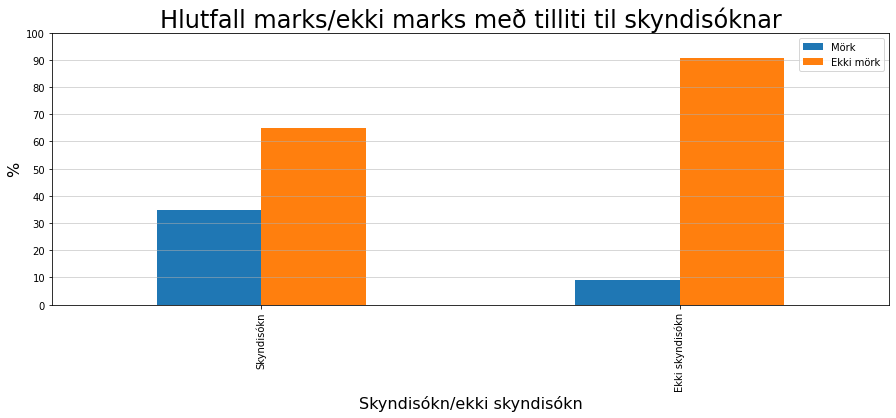

,Nr_shots,Nr_goals,%goals,%not_goal
Skyndisókn,4526,1580,34.909,65.091
Ekki skyndisókn,222151,20415,9.190,90.810


In [31]:
def GetFastbreak(data,i):
  return data[data.fast_break == i]

FB = {}
row = {}
col = {}
goals = {}
fbs = [0,1]
for i in fbs:
  FB[i] = GetFastbreak(shots,i)
  row[i], col[i] = np.shape(FB[i])
  goals[i] = FB[i].is_goal.sum()

transformer = {0	: "Ekki skyndisókn", 1:	"Skyndisókn" }

show = pd.DataFrame({'Nr_shots' : [row[i] for i in fbs],
                     'Nr_goals' : [goals[i] for i in fbs]},
                     index = [transformer[i] for i in range(2)])

show['%goals'] = round(100*show['Nr_goals'] / show['Nr_shots'],3) 
show['%not_goal'] = round(100* (show['Nr_shots'] - show['Nr_goals']) / show['Nr_shots'],3) 
show = show.sort_values(by = '%goals', ascending=False)
fig = plt.figure()
ax  = show[['%goals', '%not_goal']].plot.bar(rot=0, figsize = (15,5))
ax.legend(['Mörk', 'Ekki mörk'])
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
plt.xticks(rotation=90)
ax.set_xlabel('Skyndisókn/ekki skyndisókn',fontsize = 16)
ax.set_title('Hlutfall marks/ekki marks með tilliti til skyndisóknar', fontsize =24)
plt.show()
show



<Figure size 432x288 with 0 Axes>

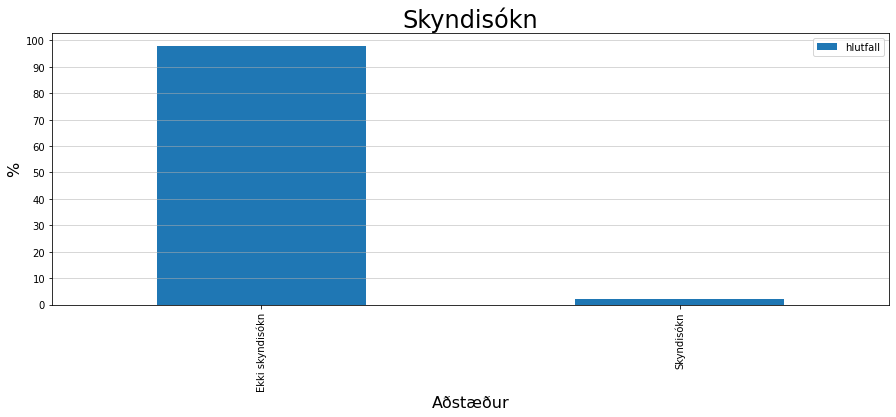

In [32]:
show = shots[['fast_break', 'id_event']].groupby(by = 'fast_break').count().reset_index().rename(columns = {'id_event' : 'count' })
show['fast_break'] = show['fast_break'].replace({0	: "Ekki skyndisókn", 1:	"Skyndisókn" })

tot = show['count'].sum()
show['hlutfall'] = round(100 * show['count'] / tot , 3)
fig = plt.figure()
ax  = show.sort_values(by='hlutfall', ascending= False).plot.bar(y = 'hlutfall', x = 'fast_break', figsize = (15,5))
ax.set_yticks(np.linspace(0,100,11))
ax.grid(axis = 'y', linewidth = 0.5)
ax.set_ylabel('%',fontsize =16)
ax.set_xlabel('Aðstæður',fontsize = 16)
ax.set_title('Skyndisókn', fontsize =24)
plt.show()

#Gögn fyrir xG módel

Gögnin sem ég hef áhuga á eru geymd í dálkunum


1.   location: Heiltala á bili [1,18]
2.   bodypart: Heiltala á bili [1,3]
3.   assist_method: Heiltala á bili [0,4]
4.   situation: Heiltala á bili [1,4]
5.   fast_break: Heiltala á bili [0,1]

Þ.e. við höfum 18 einkenni sem lýsa staðsetningu á vellinum, 3 einkenni sem lýsa hvaða líkamspartur var notaður í skoti, 5 einkenni sem lýsa hvernig stoðsending kom til, 4 einkenni sem lýsa aðstæðum þegar skotið átti sér stað og að lokum 1 einkenni sem lýsa því hvort skyndisókn átti sér stað.

$$\text{#einkenni}  = n = 18+3+5+4+1 = 31$$

ATH: Með þessari breytingu eru öll gögn sköluð á binary form þ.e. allir dálkar taka gildi sem annaðhvort eru 0 eða 1. Áður var ég að skala t.d. bilið [1,18] niður á bæði [-1,1] og [0,1].

Viðbót: Þegar að ég var búin að útfæra dummies tók ég reyndar eftir að nokkur gildi í location koma aldrei fram í gagnasettinu og að heildar einkenni hvers skots er 27.

Viðbót: Ég prófaði að velja train, val, test með mjög margvíslegum hætti. Til að mynda með hinu hefðbunda sklearn falli train_test_split en ég fékk leið á því að vera aldrei að vinna með sömu gagnasettin svo ég prófaði að skipta eftir löndum og endaði á að skipta í train,val og test eftir árum. Ástæðan fyrir því er aðallega praktísk, auðvelt að vita hvað er í hverju gagnasetti. 

Hér fyrir neðan má sjá nokkrar aðferðir sem ég notaði til að skipta gögnunum.






In [33]:
#-------------------------------------------------------------------------------
#Gögnin sem við höfum áhuga eru geymd hér. Í staðinn fyrir að nota aðeins 5 
#einkenni með mjög svo dreyfðum gildum (Ath prófaði það fyrst með ekki svo
#góðum niðurstöðum) ákvað ég að nota svokallaða dummies sem splitta þessum 5
#dálkum í 32 dálka sem eru allir 0 eða 1.
#-------------------------------------------------------------------------------
shots.iloc[:2,-8:-3]

,location,bodypart,assist_method,situation,fast_break
0,9,2,1,1,0
11,15,1,1,1,0


In [34]:
show = GetDataWithDummies(shots)
show.head(1)

,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,penalty,outside_box,long_range,more_35y,more_40y,right_foot,left_foot,header,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [35]:
#-------------------------------------------------------------------------------
#Skipta gögnum eftir árum: 
#X_test innheldur gögn frá 2012,2013,2016 og 2017
#X_val inniheldur gögn frá 2015
#X_test inniheldur gögn frá 2014
#-------------------------------------------------------------------------------
data = {}
for year in years:
  data[year] = GetDataWithDummies(Year[year]).to_numpy().astype('int64')

X_full = GetDataWithDummies(shots).to_numpy().astype('int64')
y_full = shots.is_goal.to_numpy().astype('int64')

X_train = np.concatenate((data[2012],data[2013],data[2016],data[2017]),axis=0)
y_train = np.concatenate((Year[2012].is_goal.to_numpy().astype('int64'), 
                          Year[2013].is_goal.to_numpy().astype('int64'),
                          Year[2016].is_goal.to_numpy().astype('int64'),
                          Year[2017].is_goal.to_numpy().astype('int64')),
                         axis=0) 
X_val = data[2015]
y_val = Year[2015].is_goal.to_numpy().astype('int64')
X_test = data[2014]
y_test = Year[2014].is_goal.to_numpy().astype('int64')
#-------------------------------------------------------------------------------
#Við þurfum bara validation sett fyrir tauganetið þannig séð, ég nota k-fold 
#crossvalidation fyrir hin módelin.
#-------------------------------------------------------------------------------
X_train_w_o_val = np.concatenate((X_train,X_val),axis=0)
y_train_w_o_val = np.concatenate((y_train,y_val),axis=0)



print('X_train shape: ',np.shape(X_train), '   y_train shape:   ',np.shape(y_train))
print('X_train án val:',np.shape(X_train_w_o_val),'   y_train án val:  ', np.shape(y_train_w_o_val) )
print('X_val shape:   ',np.shape(X_val), '    y_val shape:     ',np.shape(y_val))
print('X_test shape:  ',np.shape(X_test),'    y_test shape:    ', np.shape(y_test) )
print('X_full shape:  ',np.shape(X_full),'   y_full shape:    ',np.shape(y_full))
printline()
print('Hlutfall marka, y_train:       ' ,round(100*np.sum(y_train)/len(y_train),3),'%')
print('Hlutfall marka, y_train án val:' ,round(100*np.sum(y_train_w_o_val)/len(y_train_w_o_val),3),'%')
print('Hlutfall marka, y_val:         ' ,round(100*np.sum(y_val)/len(y_val),3),'%')
print('Hlutfall marka, y_test:        ' ,round(100*np.sum(y_test)/len(y_test),3),'%')
print('Hlutfall marka, y_full:        ' ,round(100*np.sum(y_full)/len(y_full),3),'%')
printline()
row1, col1 = np.shape(np.unique(X_train,axis=0))
row2, col2 = np.shape(np.unique(X_val,axis=0))
row3, col3 = np.shape(np.unique(X_test,axis=0))
row4, col4 = np.shape(np.unique(X_full,axis=0))
row5, col5 = np.shape(np.unique(X_train_w_o_val,axis=0))
print('Fjöldi tegunda skota í X_train:          ',row1)
print('Fjöldi tegunda skota í X_train án val:   ',row5)
print('Fjöldi tegunda skota í X_val:            ',row2)
print('Fjöldi tegunda skota í X_test:           ',row3)
print('Fjöldi tegunda skota í X_full:           ',row4)
printline()




X_train shape:  (138847, 27)    y_train shape:    (138847,)
X_train án val: (182597, 27)    y_train án val:   (182597,)
X_val shape:    (43750, 27)     y_val shape:      (43750,)
X_test shape:   (44080, 27)     y_test shape:     (44080,)
X_full shape:   (226677, 27)    y_full shape:     (226677,)
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Hlutfall marka, y_train:        9.747 %
Hlutfall marka, y_train án val: 9.698 %
Hlutfall marka, y_val:          9.543 %
Hlutfall marka, y_test:         9.723 %
Hlutfall marka, y_full:         9.703 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi tegunda skota í X_train:           538
Fjöldi tegunda skota í X_train án val:    549
Fjöldi tegunda skota í X_val:             441
Fjöldi tegunda skota í X_test:            444
Fjöldi tegunda skota í X_full:            562
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [36]:
#-------------------------------------------------------------------------------
#Skipta gögnum eftir löndum
#-------------------------------------------------------------------------------
'''
data['eng'] = GetDataWithDummies(England).to_numpy().astype('int64')
data['ger'] = GetDataWithDummies(Germany).to_numpy().astype('int64')
data['ita'] = GetDataWithDummies(Italy).to_numpy().astype('int64')
data['spn'] = GetDataWithDummies(Spain).to_numpy().astype('int64')
data['fra'] = GetDataWithDummies(France).to_numpy().astype('int64')

X_train = np.concatenate((data['spn'],data['eng'],data['ita']),axis=0)
X_val = data['fra']
X_test = data['ger']

y_train = np.concatenate((Spain.is_goal.to_numpy().astype('int64'), 
                          England.is_goal.to_numpy().astype('int64'),
                          Italy.is_goal.to_numpy().astype('int64')),
                         axis=0)
y_val = France.is_goal.to_numpy().astype('int64')
y_test = Germany.is_goal.to_numpy().astype('int64')


print('X_train shape: ',np.shape(X_train), '   y_train shape:   ',np.shape(y_train))
print('X_val shape:   ',np.shape(X_val), '    y_val shape:      ',np.shape(y_val))
print('X_test shape:  ',np.shape(X_test),'    y_test shape:     ', np.shape(y_test) )
printline()
print('Hlutfall marka, y_train:   ' ,round(100*np.sum(y_train)/len(y_train),3),'%')
print('Hlutfall marka, y_val:     ' ,round(100*np.sum(y_val)/len(y_val),3),'%')
print('Hlutfall marka, y_test:    ' ,round(100*np.sum(y_test)/len(y_test),3),'%')
printline()
row1, col1 = np.shape(np.unique(X_train,axis=0))
row2, col2 = np.shape(np.unique(X_val,axis=0))
row3, col3 = np.shape(np.unique(X_test,axis=0))
row4, col4 = np.shape(np.unique(X_full,axis=0))
print('Fjöldi tegunda skota í X_train:          ',row1)
print('Fjöldi tegunda skota í X_val:            ',row2)
print('Fjöldi tegunda skota í X_test:           ',row3)
print('Fjöldi tegunda skota í X_full:           ',row4)
printline()
'''

"\ndata['eng'] = GetDataWithDummies(England).to_numpy().astype('int64')\ndata['ger'] = GetDataWithDummies(Germany).to_numpy().astype('int64')\ndata['ita'] = GetDataWithDummies(Italy).to_numpy().astype('int64')\ndata['spn'] = GetDataWithDummies(Spain).to_numpy().astype('int64')\ndata['fra'] = GetDataWithDummies(France).to_numpy().astype('int64')\n\nX_train = np.concatenate((data['spn'],data['eng'],data['ita']),axis=0)\nX_val = data['fra']\nX_test = data['ger']\n\ny_train = np.concatenate((Spain.is_goal.to_numpy().astype('int64'), \n                          England.is_goal.to_numpy().astype('int64'),\n                          Italy.is_goal.to_numpy().astype('int64')),\n                         axis=0)\ny_val = France.is_goal.to_numpy().astype('int64')\ny_test = Germany.is_goal.to_numpy().astype('int64')\n\n\nprint('X_train shape: ',np.shape(X_train), '   y_train shape:   ',np.shape(y_train))\nprint('X_val shape:   ',np.shape(X_val), '    y_val shape:      ',np.shape(y_val))\nprint('X_t

In [37]:
#-------------------------------------------------------------------------------
#Skipta gögnum með train_test_split
#-------------------------------------------------------------------------------
'''
from sklearn.model_selection import train_test_split
X_np = shots_w_dummies.to_numpy().astype('int64')
y_np = shots['is_goal'].to_numpy().astype('int64')
row, col = np.shape(X_np)
roww = len(y_np)
printline()
row, col  = np.shape(shots_w_dummies)
print('Stærð gagnasetts sem ég mun nota:')
print('Fjöldi lína í X:            ', row)
print('Fjöldi dálka/einkenna í X:  ',col)
print('Fjöldi lína í y:            ',roww)
printline()

X_temp, X_test, y_temp, y_test = train_test_split(X_np,y_np,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp,test_size=0.25)

print('X_train shape: ',np.shape(X_train), '   y_train shape:   ',np.shape(y_train))
#print('w/o val set:   ',np.shape(X_train_and_val), '   y_train shape:   ', np.shape(y_train_and_val) )
print('X_val shape:   ',np.shape(X_val), '    y_val shape:      ',np.shape(y_val))
print('X_test shape:  ',np.shape(X_test),'    y_test shape:     ', np.shape(y_test) )
printline()
print('Hlutfall marka, y_train:   ' ,round(100*np.sum(y_train)/len(y_train),3),'%')
print('Hlutfall marka, y_val:     ' ,round(100*np.sum(y_val)/len(y_val),3),'%')
print('Hlutfall marka, y_test:    ' ,round(100*np.sum(y_test)/len(y_test),3),'%')
printline()
row1, col1 = np.shape(np.unique(X_train,axis=0))
row2, col2 = np.shape(np.unique(X_val,axis=0))
row3, col3 = np.shape(np.unique(X_test,axis=0))
row4, col4 = np.shape(np.unique(X_np,axis=0))
print('Fjöldi tegunda skota í X_train:          ',row1)
print('Fjöldi tegunda skota í X_val:            ',row2)
print('Fjöldi tegunda skota í X_test:           ',row3)
print('Fjöldi tegunda skota í öllu gagnasetti:  ',row4)
printline()
'''

"\nfrom sklearn.model_selection import train_test_split\nX_np = shots_w_dummies.to_numpy().astype('int64')\ny_np = shots['is_goal'].to_numpy().astype('int64')\nrow, col = np.shape(X_np)\nroww = len(y_np)\nprintline()\nrow, col  = np.shape(shots_w_dummies)\nprint('Stærð gagnasetts sem ég mun nota:')\nprint('Fjöldi lína í X:            ', row)\nprint('Fjöldi dálka/einkenna í X:  ',col)\nprint('Fjöldi lína í y:            ',roww)\nprintline()\n\nX_temp, X_test, y_temp, y_test = train_test_split(X_np,y_np,test_size=0.2)\nX_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp,test_size=0.25)\n\nprint('X_train shape: ',np.shape(X_train), '   y_train shape:   ',np.shape(y_train))\n#print('w/o val set:   ',np.shape(X_train_and_val), '   y_train shape:   ', np.shape(y_train_and_val) )\nprint('X_val shape:   ',np.shape(X_val), '    y_val shape:      ',np.shape(y_val))\nprint('X_test shape:  ',np.shape(X_test),'    y_test shape:     ', np.shape(y_test) )\nprintline()\nprint('Hlutfall mar

In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#-------------------------------------------------------------------------------
#Gamla aðferðin með 5 einkennum og skölun
#-------------------------------------------------------------------------------
'''
cols = ['id_event', 'location', 'bodypart','assist_method','situation',
        'fast_break']
X_DataFrame = shots[cols].copy()
y_DataFrame = shots[['id_event','is_goal']].copy()

#-------------------------------------------------------------------------------
#Breytum í numpy array
#-------------------------------------------------------------------------------
cols = ['location',	'bodypart',	'assist_method',	'situation',	'fast_break']
X_np = X_DataFrame[cols].to_numpy().astype('float64')
y_np = y_DataFrame['is_goal'].to_numpy()
#-------------------------------------------------------------------------------
#Skölum gildin í hverjum dálk frá -1 to 1 og stokkum. ATH: X_np er ennþá í
#réttri röð en X er stokkað. Notum X_np á eftir!!!!
#kóði til að vista gögnin, svo ég geti notað sömu gögn á fleiri stöðum
#-------------------------------------------------------------------------------
#np.savetxt("X.csv", X_np, delimiter=",")
#np.savetxt("y.csv", y_np, delimiter=",")


X_temp, X_ts, y_temp, y_test = train_test_split(X_np,y_np,test_size=0.2)
X_tr, X_v, y_train, y_val = train_test_split(X_temp,y_temp,test_size=0.25)

X = {'ints' : X_np, 'scaled' : MyScaler(X_np)}
X_train = {'ints' : X_tr, 'scaled' : MyScaler(X_tr)}
X_val = {'ints' : X_v, 'scaled' : MyScaler(X_v)}
X_train_and_val = {'ints' : np.concatenate((X_train['ints'], X_val['ints']), axis=0),
                   'scaled' : np.concatenate((X_train['scaled'], X_val['scaled']), axis=0)}
y_train_and_val = np.concatenate((y_train,y_val),axis=0)
X_test = {'ints' : X_ts, 'scaled' : MyScaler(X_ts)}


printline()
print('X_train shape: ',np.shape(X_train['ints']), '   y_train shape:   ',np.shape(y_train))
print('w/o val set:   ',np.shape(X_train_and_val['ints']), '   y_train shape:   ', np.shape(y_train_and_val) )
print('X_val shape:   ',np.shape(X_val['ints']), '    y_val shape:      ',np.shape(y_val))
print('X_test shape:  ',np.shape(X_test['ints']),'    y_test shape:     ', np.shape(y_test) )
printline()
print('Hlutfall marka, y_train:   ' ,round(100*np.sum(y_train)/len(y_train),3),'%')
print('Hlutfall marka, y_val:     ' ,round(100*np.sum(y_val)/len(y_val),3),'%')
print('Hlutfall marka, y_test:    ' ,round(100*np.sum(y_test)/len(y_test),3),'%')
printline()
row1, col1 = np.shape(np.unique(X_train['ints'],axis=0))
row2, col2 = np.shape(np.unique(X_val['ints'],axis=0))
row3, col3 = np.shape(np.unique(X_test['ints'],axis=0))
row4, col4 = np.shape(np.unique(X_np,axis=0))
print('Fjöldi tegunda skota í X_train:          ',row1)
print('Fjöldi tegunda skota í X_val:            ',row2)
print('Fjöldi tegunda skota í X_test:           ',row3)
print('Fjöldi tegunda skota í öllu gagnasetti:  ',row4)
printline()




#Var eitthvað að pæla í vigtum en hætti við þá pælingu, þar brenglaði líkurnar
#n_samples = np.shape(X_train)[0]
#n_samples_Goal = np.sum(y_train)
#n_samples_No_Goal = n_samples - n_samples_Goal
#Vigtir
#w0 = n_samples / (2*n_samples_No_Goal)
#w1 = n_samples / (2*n_samples_Goal)
#print(round(w0,4),round(w1,4))
'''

'\ncols = [\'id_event\', \'location\', \'bodypart\',\'assist_method\',\'situation\',\n        \'fast_break\']\nX_DataFrame = shots[cols].copy()\ny_DataFrame = shots[[\'id_event\',\'is_goal\']].copy()\n\n#-------------------------------------------------------------------------------\n#Breytum í numpy array\n#-------------------------------------------------------------------------------\ncols = [\'location\',\t\'bodypart\',\t\'assist_method\',\t\'situation\',\t\'fast_break\']\nX_np = X_DataFrame[cols].to_numpy().astype(\'float64\')\ny_np = y_DataFrame[\'is_goal\'].to_numpy()\n#-------------------------------------------------------------------------------\n#Skölum gildin í hverjum dálk frá -1 to 1 og stokkum. ATH: X_np er ennþá í\n#réttri röð en X er stokkað. Notum X_np á eftir!!!!\n#kóði til að vista gögnin, svo ég geti notað sömu gögn á fleiri stöðum\n#-------------------------------------------------------------------------------\n#np.savetxt("X.csv", X_np, delimiter=",")\n#np.savet

#Samanburðar módel

In [39]:
#-------------------------------------------------------------------------------
#Byggjum samanburðar módel, sem eingöngu metur hvort skot hafi verið mark eða 
#ekki útfrá staðsetningu
#-------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
sbr_model = LogisticRegression(max_iter=10000, C=2.782559402207126)
sbr_model.fit(X_train_w_o_val[:,1:15],y_train_w_o_val)
y_fit = sbr_model.predict(X_test[:,1:15])
tot_goals = np.sum(y_test)
tot_xG = np.sum(sbr_model.predict_proba(X_test[:,1:15])[:,1])
acc_score = round(100*accuracy_score(y_test,y_fit),3)
conf_mat = confusion_matrix(y_test,y_fit)
printline()
printline()
print('Classification report:')
print()
print(classification_report(y_test,y_fit))
printline()
print('Confusion matrix:')
print()
printarr(conf_mat)
printline()
print('Accuracy score:',acc_score,'%')
print()
printline()
print('Total goals in test data:    ',tot_goals)
print('Summed expected goals:       ',tot_xG)
printline()

from sklearn.metrics import brier_score_loss
brier_loss = brier_score_loss(y_test,sbr_model.predict_proba(X_test[:,1:15])[:,1])
print(brier_loss)



-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Classification report:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     39794
           1       0.75      0.08      0.15      4286

    accuracy                           0.91     44080
   macro avg       0.83      0.54      0.55     44080
weighted avg       0.89      0.91      0.87     44080

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Confusion matrix:


39678   116   
3937   349   

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Accuracy score: 90.805 %

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Total goals in test data:     4286
Summed expected goals:        4214.634053611549
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
0.07

In [40]:
best2worst_shots = shots.drop_duplicates(subset = ['location']).sort_values(by = 'location',ascending = True).reset_index(drop=True)
best2worst_shots_dummies = pd.get_dummies(data = best2worst_shots['location']).reset_index(drop=True)

best2worst_shots['xG'] = sbr_model.predict_proba(best2worst_shots_dummies)[:,1]

show  = best2worst_shots[['location', 'xG']]

show['location'] =  show['location'].replace({1:	"Attacking half",2	: "Defensive half", 3:	"Centre of the box",4:	"Left wing",5:	"Right wing",6:"Difficult angle and long range",
                                             7:	"Difficult angle on the left",8:	"Difficult angle on the right",9:	"Left side of the box",10:	"Left side of the six yard box",
                                             11:	"Right side of the box",12:	"Right side of the six yard box",13:	"Very close range",14:	"Penalty spot",15:	"Outside the box",
                                              16:	"Long range",17:	"More than 35 yards",18:	"More than 40 yards"})

print(show.to_latex(index=False))
show



\begin{tabular}{lr}
\toprule
                       location &        xG \\
\midrule
 Centre of the box &  0.147837 \\
 Difficult angle and long range &  0.027143 \\
 Difficult angle on the left &  0.073782 \\
 Difficult angle on the right &  0.071467 \\
 Left side of the box &  0.063399 \\
 Left side of the six yard box &  0.198089 \\
 Right side of the box &  0.066373 \\
 Right side of the six yard box &  0.197688 \\
 Very close range &  0.485453 \\
 Penalty spot &  0.758733 \\
 Outside the box &  0.026119 \\
 Long range &  0.012377 \\
 More than 35 yards &  0.011373 \\
 More than 40 yards &  0.013305 \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,location,xG
0,Centre of the box,0.147837
1,Difficult angle and long range,0.027143
2,Difficult angle on the left,0.073782
3,Difficult angle on the right,0.071467
4,Left side of the box,0.063399
5,Left side of the six yard box,0.198089
6,Right side of the box,0.066373
7,Right side of the six yard box,0.197688
8,Very close range,0.485453
9,Penalty spot,0.758733


#Módel

##Logistic Regression

###Hyperparameter tuning

ÉG byrja á að finna bestu hyperparametra fyrir reikniritið. Ég geri c.a. tvær umferðir, Tek bestu niðurstöður úr fyrstu umferð og þrengi leitina einu einni. Nota Random grid, með c.a. 10 ítrunum og þreföldu cross-val. Geri það tvisvar.

In [41]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Hér er ég aða prófa Logistic regression.
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------


'''
#Grid search stuff
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'C':[0.001,.009,0.01,.09,1,5,10,25],
          'class_weight' : ['balanced', 'none'],
          'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
               }

#max_iter=10000, C=2.782559402207126



Log_Reg_Model = LogisticRegression(max_iter=10000)
rnd_search = RandomizedSearchCV(Log_Reg_Model, params, n_iter=10,
                                     scoring=['accuracy', 'f1', 'recall', 'roc_auc', 'precision'],
                                     refit= 'recall', cv=3, verbose=1)
rnd_search.fit(X_train_w_o_val,y_train_w_o_val)


scores = rnd_search.cv_results_
score = pd.DataFrame.from_dict(scores)
score

'''




"\n#Grid search stuff\nparams = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],\n          'C':[0.001,.009,0.01,.09,1,5,10,25],\n          'class_weight' : ['balanced', 'none'],\n          'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']\n               }\n\n#max_iter=10000, C=2.782559402207126\n\n\n\nLog_Reg_Model = LogisticRegression(max_iter=10000)\nrnd_search = RandomizedSearchCV(Log_Reg_Model, params, n_iter=10,\n                                     scoring=['accuracy', 'f1', 'recall', 'roc_auc', 'precision'],\n                                     refit= 'recall', cv=3, verbose=1)\nrnd_search.fit(X_train_w_o_val,y_train_w_o_val)\n\n\nscores = rnd_search.cv_results_\nscore = pd.DataFrame.from_dict(scores)\nscore\n\n"

In [42]:
'''
y_pred = rnd_search.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
xG = rnd_search.predict_proba(X_test)[:,1]
print(np.sum(xG))
print(np.sum(y_test))
'''

'\ny_pred = rnd_search.predict(X_test)\nprint(classification_report(y_test,y_pred))\nprint(confusion_matrix(y_test,y_pred))\nxG = rnd_search.predict_proba(X_test)[:,1]\nprint(np.sum(xG))\nprint(np.sum(y_test))\n'

In [43]:
'''
model = LogisticRegression(solver= 'newton-cg', penalty= 'none', class_weight= 'balanced', C =  0.009)
model.fit(X_train_w_o_val,y_train_w_o_val)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
xG = model.predict_proba(X_test)[:,1]
print(np.sum(xG))
print(np.sum(y_test))
print(accuracy_score(y_test,y_pred))
'''

"\nmodel = LogisticRegression(solver= 'newton-cg', penalty= 'none', class_weight= 'balanced', C =  0.009)\nmodel.fit(X_train_w_o_val,y_train_w_o_val)\ny_pred = model.predict(X_test)\nprint(classification_report(y_test,y_pred))\nprint(confusion_matrix(y_test,y_pred))\nxG = model.predict_proba(X_test)[:,1]\nprint(np.sum(xG))\nprint(np.sum(y_test))\nprint(accuracy_score(y_test,y_pred))\n"

In [44]:
'''
params = {'penalty': ['l2','none'], 'class_weight': ['balanced', 'none'], 'C': [0.001,.009,0.01,.09,1,5,10,25,50,100]}

rnd_search_2 = RandomizedSearchCV(LogisticRegression(max_iter=10000, solver = 'lbfgs'), params,
                    scoring = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'], 
                    cv = 3, refit = 'accuracy',
                    n_iter = 10)
rnd_search_2.fit(X_train_w_o_val,y_train_w_o_val)

scores = rnd_search_2.cv_results_
score = pd.DataFrame.from_dict(scores)
score
'''


"\nparams = {'penalty': ['l2','none'], 'class_weight': ['balanced', 'none'], 'C': [0.001,.009,0.01,.09,1,5,10,25,50,100]}\n\nrnd_search_2 = RandomizedSearchCV(LogisticRegression(max_iter=10000, solver = 'lbfgs'), params,\n                    scoring = ['accuracy', 'f1', 'recall', 'roc_auc', 'precision'], \n                    cv = 3, refit = 'accuracy',\n                    n_iter = 10)\nrnd_search_2.fit(X_train_w_o_val,y_train_w_o_val)\n\nscores = rnd_search_2.cv_results_\nscore = pd.DataFrame.from_dict(scores)\nscore\n"

###Niðurstöður Logistic Regression

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Cross validation results:

Mean cross val score: fit_time :   5.847
Mean cross val score: score_time :   0.082
Mean cross val score: test_accuracy :   0.913
Mean cross val score: test_f1 :   0.32
Mean cross val score: test_recall :   0.211
Mean cross val score: test_roc_auc :   0.804
Mean cross val score: test_precision :   0.658
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Classification r

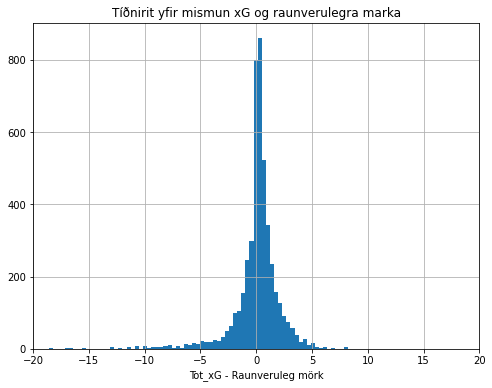

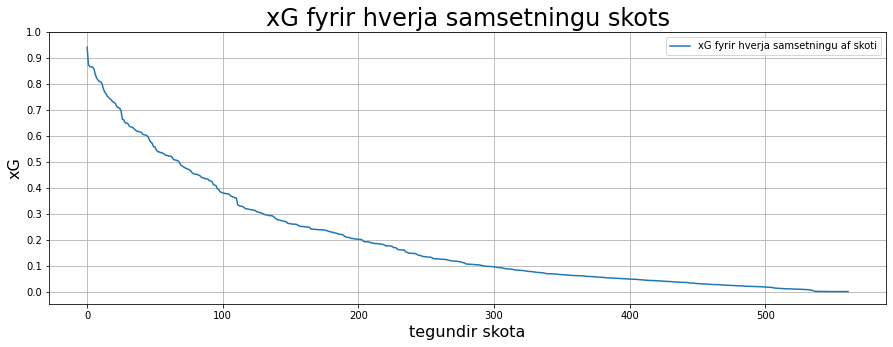

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


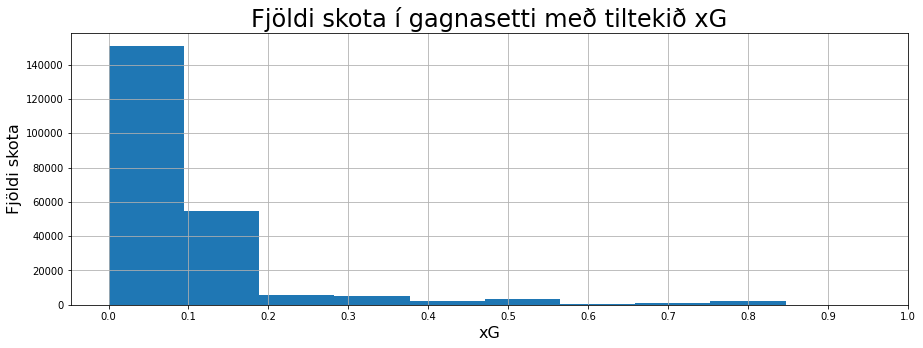

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


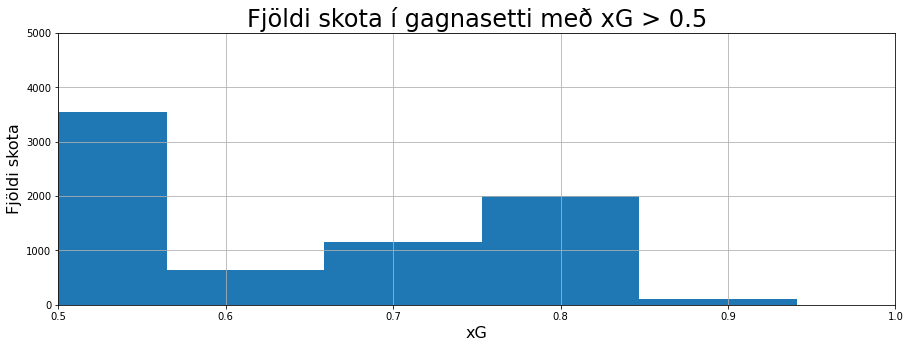

,0,1,2,3,4
fit_time,4.837670,4.109338,5.469003,5.848794,8.969892
score_time,0.076665,0.092268,0.080068,0.078633,0.081599
test_accuracy,0.912788,0.913445,0.911662,0.913360,0.913086
test_f1,0.325355,0.320945,0.304442,0.319277,0.329531
test_recall,0.216827,0.210898,0.199379,0.209486,0.220215
test_roc_auc,0.810319,0.805677,0.802325,0.800155,0.799049
test_precision,0.651399,0.671159,0.643573,0.670886,0.654362


In [45]:
#Nota hér þá parametra sem ég var sáttastur með
Log_Reg_Model = LogisticRegression(solver= 'lbfgs', penalty= 'l2', class_weight= 'none', C =  10, max_iter = 1000)

#Köllum á train_and_evaluate fallið sem ég bjó til
train_and_evaluate(Log_Reg_Model,X_train_w_o_val,X_test,y_train_w_o_val,y_test,'Log_Reg')

In [46]:
from sklearn.metrics import brier_score_loss
brier_loss = brier_score_loss(y_test,Log_Reg_Model.predict_proba(X_test)[:,1])
print(brier_loss)

0.07204323108083095


In [47]:
DisplayByFeature('Log_Reg','_mismunur',5,goals_over=20)

,player,total_goals,Log_Reg_xG,Log_Reg_mismunur,Log_Reg_hlutfall
0,Lionel Messi,186,126.289580,-59.707,1.473
1,Gonzalo Higuain,115,81.236625,-33.742,1.416
2,Luis Suarez,90,57.134095,-32.858,1.575
3,Zlatan Ibrahimovic,139,106.745570,-32.226,1.302
4,Cristiano Ronaldo,175,145.203176,-29.760,1.205


##Random Forrest

In [48]:
np.arange(2,21)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])

###Hyperparameter tuning

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


'''
model = RandomForestClassifier()
params = {'n_estimators' : np.arange(10,101),
          'min_samples_split' : np.arange(2,21),
          'bootstrap' : [True,False],
          'min_samples_leaf' : np.arange(1,6)
          }

rand_search = RandomizedSearchCV(model,params,n_iter=20,
                                 cv=3,scoring = ['accuracy', 'precision','recall', 'roc_auc', 'f1'],
                                 refit='accuracy')
rand_search.fit(X_train_w_o_val,y_train_w_o_val)

scores = rand_search.cv_results_
score = pd.DataFrame(scores).sort_values(by = 'rank_test_accuracy').reset_index(drop=True)
score
'''
#{'n_estimators': 56, 'min_samples_split': 14, 'min_samples_leaf': 1, 'bootstrap': True}

"\nmodel = RandomForestClassifier()\nparams = {'n_estimators' : np.arange(10,101),\n          'min_samples_split' : np.arange(2,21),\n          'bootstrap' : [True,False],\n          'min_samples_leaf' : np.arange(1,6)\n          }\n\nrand_search = RandomizedSearchCV(model,params,n_iter=20,\n                                 cv=3,scoring = ['accuracy', 'precision','recall', 'roc_auc', 'f1'],\n                                 refit='accuracy')\nrand_search.fit(X_train_w_o_val,y_train_w_o_val)\n\nscores = rand_search.cv_results_\nscore = pd.DataFrame(scores).sort_values(by = 'rank_test_accuracy').reset_index(drop=True)\nscore\n"

###Niðurstöður Random Forest

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Cross validation results:

Mean cross val score: fit_time :   5.521
Mean cross val score: score_time :   0.558
Mean cross val score: test_accuracy :   0.913
Mean cross val score: test_f1 :   0.318
Mean cross val score: test_recall :   0.21
Mean cross val score: test_roc_auc :   0.803
Mean cross val score: test_precision :   0.653
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=56,
  

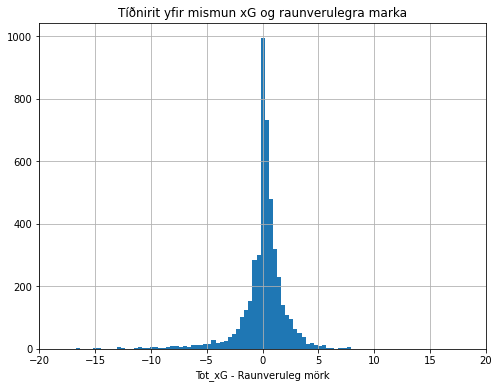

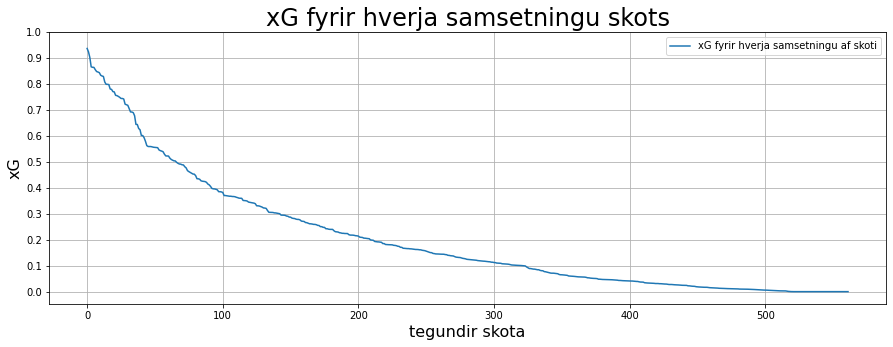

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


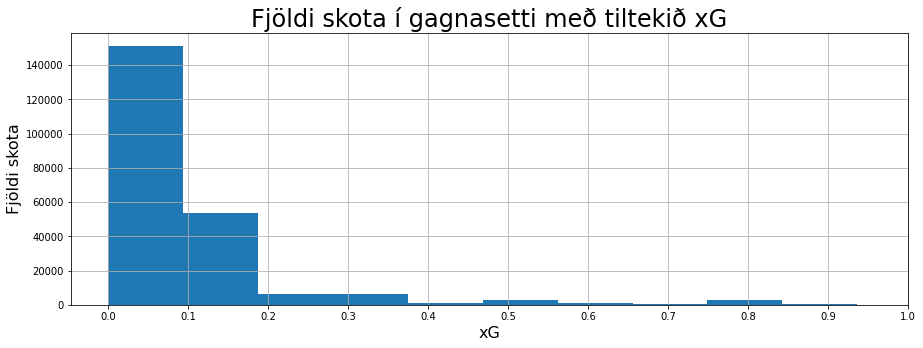

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


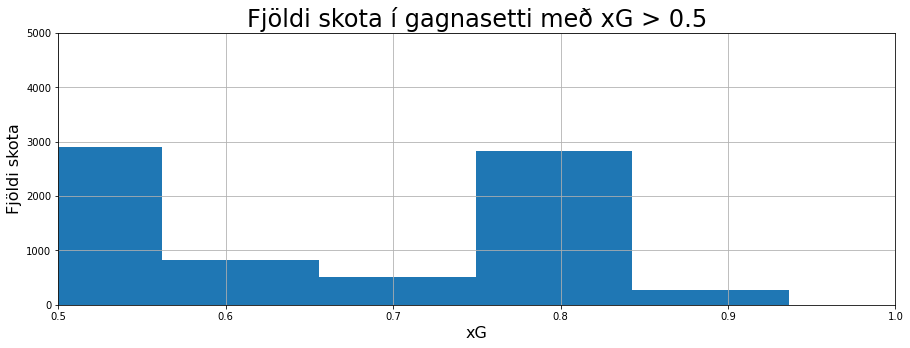

,0,1,2,3,4
fit_time,5.367222,4.962587,5.084392,6.082186,6.109296
score_time,0.551904,0.547032,0.545829,0.543735,0.601027
test_accuracy,0.912705,0.913061,0.911690,0.912457,0.912922
test_f1,0.329407,0.319400,0.299978,0.309354,0.329680
test_recall,0.221062,0.210333,0.195143,0.202146,0.220779
test_roc_auc,0.809937,0.804935,0.803669,0.799364,0.797789
test_precision,0.646040,0.663402,0.648218,0.658694,0.650582


In [50]:



RandomForrest = RandomForestClassifier(min_samples_split=14,  n_estimators = 56,
                                       min_samples_leaf = 1, bootstrap = True)
train_and_evaluate(RandomForrest,
                   X_tr=X_train_w_o_val, X_ts= X_test,
                   y_tr= y_train_w_o_val, y_ts=y_test,
                   Model_name='RF')



In [51]:
print('Brier', brier_score_loss(y_test,RandomForrest.predict_proba(X_test)[:,1]))

Brier 0.07185112891773827


In [52]:
DisplayByFeature(feature_inp='_mismunur',model='RF',nr=6000).tail()

,player,total_goals,RF_xG,RF_mismunur,RF_hlutfall
4719,Giampaolo Pazzini,28,35.834531,7.825,0.781
4720,Mats Hummels,8,16.598648,8.591,0.482
4721,Adrian Mutu,14,22.768334,8.747,0.615
4722,Amauri,20,30.511879,10.504,0.655
4723,Jesus Navas,9,22.814855,13.776,0.394


##Tauganet 1

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from keras import regularizers
#-------------------------------------------------------------------------------
#Er að búa til basic tauganet til að leysa þetta verkefni.
#Kommenta þetta út því ég bjó til tauganetið, þjáfliði og save-aði svo besta 
#módeli sem ég load-a úr minni þegar ég framkvæmi predictions.
#-------------------------------------------------------------------------------
'''
input_ = keras.layers.Input(shape = (27,), name = 'input')
hidden0 = keras.layers.Dense(1024, activation='relu', name = 'hidden0')(input_)
hidden1 = keras.layers.Dense(512, activation='relu', name = 'hidden1')(hidden0)
hidden2 = keras.layers.Dense(256,activation='relu', name = 'hidden2')(hidden1)
hidden3 = keras.layers.Dense(128,activation='relu', name = 'hidden3')(hidden2)
output_ = keras.layers.Dense(2,activation='softmax',name='output')(hidden3)

model_1 = keras.Model(inputs = input_, outputs = output_)
model_1.summary()



'''
#-------------------------------------------------------------------------------
#Compile og stuff
#early stopping og callbacks.
#ModelCheakpoint sér til þess að besta módelið á validation settinu hingað til 
#er alltaf save-að. Þá þurfum við ekki að hafa áhyggjur af því að þjálfa of
#lengi.
#The number of epochs can be set to a large value since training will stop
#automatically when there is no more progress. In this case, there is no need 
#to restore the best model saved because the EarlyStopping callback will keep 
#track of the best weights and restore them for you at the end of training.
#Modelið sem ég fæ út er svo bara save-að hjá mér svo ég kommenta þetta út.
#-------------------------------------------------------------------------------

#sgd = keras.optimizers.SGD(lr=0.01)

'''
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adagrad",
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10,
                                                  restore_best_weights = True)

cheakpoint_cb = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_1',
                                                save_best_only=True)

history = model_1.fit(X_train_w_o_val, y_train_w_o_val, epochs = 500,
                    batch_size = 32,
                    validation_split=0.2,
                    callbacks = [cheakpoint_cb,
                                 early_stopping_cb])
                              
'''

'\nmodel_1.compile(loss="sparse_categorical_crossentropy",\n              optimizer= "adagrad",\n              metrics=["accuracy"])\n\nearly_stopping_cb = keras.callbacks.EarlyStopping(patience = 10,\n                                                  restore_best_weights = True)\n\ncheakpoint_cb = keras.callbacks.ModelCheckpoint(\n    \'/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_1\',\n                                                save_best_only=True)\n\nhistory = model_1.fit(X_train_w_o_val, y_train_w_o_val, epochs = 500,\n                    batch_size = 32,\n                    validation_split=0.2,\n                    callbacks = [cheakpoint_cb,\n                                 early_stopping_cb])\n                              \n'

###Niðurstöður tauganets 1

In [54]:
#-------------------------------------------------------------------------------
#load-a tauganetinu úr minni, þar eru geymdar allar vigtir og bygging nets.
#-------------------------------------------------------------------------------
#model_1.save_model('model_1.h5')
#model_1 = keras.models.load_model('model_1.h5')
model_1 = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_1'
    ) 

y_pred = model_1.predict(X_test)
y_proba = y_pred[:,1]
pred_class = np.argmax(y_pred,axis=1)
Show_Results(model_1,X_test,y_test,pred_class,y_proba)
print()
print('Brier', brier_score_loss(y_test,model_1.predict(X_test)[:,1]))
'''
#plottum frammistöðu stika nets eftir epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
'''
#Bætum nýja xG-inu í gagnasettið
shots['NN_1_xG'] = model_1.predict(X_full)[:,1]
shots['NN_1_mismunur'] = round(shots['NN_1_xG'] - shots['is_goal'] ,3)

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     39794
           1       0.66      0.21      0.31      4286

    accuracy                           0.91     44080
   macro avg       0.79      0.60      0.63     44080
weighted avg       0.89      0.91      0.89     44080

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Confusion matrix:


39330   464   
3399   887   

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Accuracy score: 91.236 %

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Total goals in test data:     4286
Summed expected goals:        4150.0493
RMSE á test gögnum            0.07176205314669097
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

NN_model
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Meðal hlutfall (mörk/xG):             0.8005
Meðal mismunur marka og xG (xG-mörk)  -0.0683
Fjöldi marka í gagnasettinu:                      21995
Fjöldi spáðra marka (heildar xG) í gagnasettinu:  21694.273
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


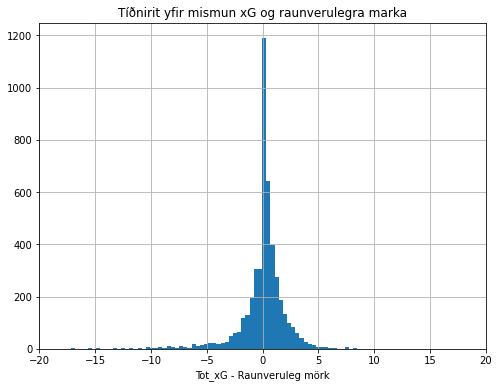

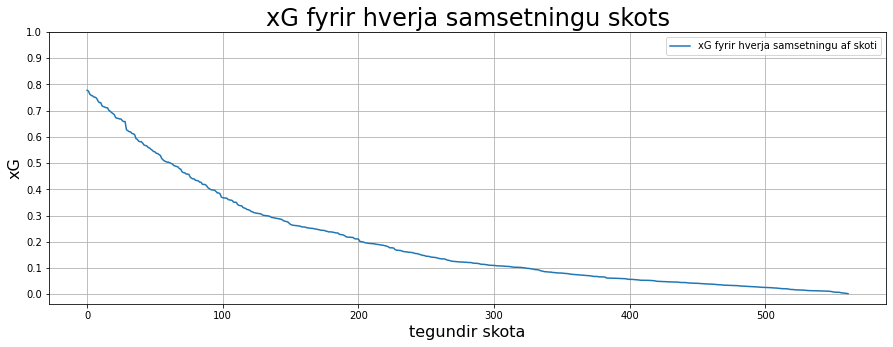

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


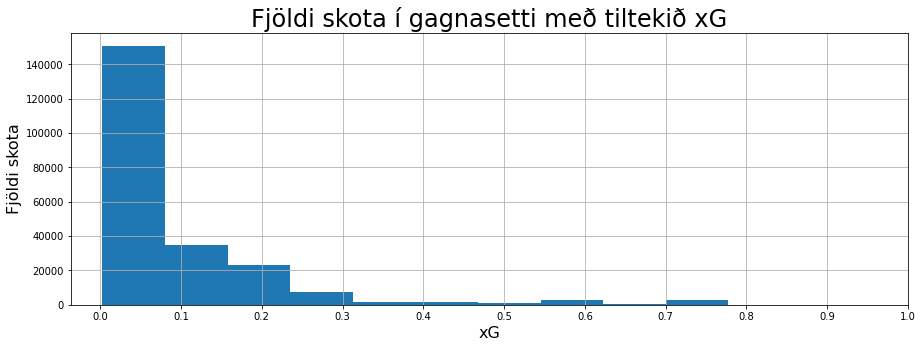

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


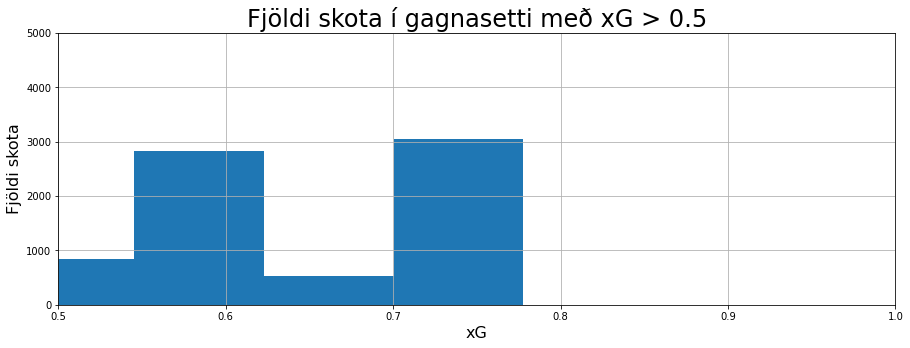

In [55]:
group = shots[['player', 'NN_1_xG', 'NN_1_mismunur']].groupby(by = 'player', as_index = False).sum().reset_index()
players = players.merge(group[['player', 'NN_1_xG', 'NN_1_mismunur']],
                      on = 'player',
                      how = 'left')
players['NN_1_hlutfall'] = round(players['total_goals'] / players['NN_1_xG'],3)
PlotxGMinusRealGoals(model = 'NN_1', model_name = 'NN_model')
EvaluateModel('NN_1_xG')

##GradientBoostingClassifier

In [56]:
'''
params = {'loss' : ['deviance', 'exponential'],
          'learning_rate' : [0.001, 0.01, 0.1, 1],
          'n_estimators' : [20*i for i in range(1,6) ]}
rnd = RandomizedSearchCV(GradientBoostingClassifier(), params,n_iter=10,cv = 2,
                         scoring= ['accuracy', 'precision', 'recall','f1'],refit='accuracy')
rnd.fit(X_train_w_o_val,y_train_w_o_val)
score = rnd.cv_results_
scores = pd.DataFrame(score)
scores
'''

"\nparams = {'loss' : ['deviance', 'exponential'],\n          'learning_rate' : [0.001, 0.01, 0.1, 1],\n          'n_estimators' : [20*i for i in range(1,6) ]}\nrnd = RandomizedSearchCV(GradientBoostingClassifier(), params,n_iter=10,cv = 2,\n                         scoring= ['accuracy', 'precision', 'recall','f1'],refit='accuracy')\nrnd.fit(X_train_w_o_val,y_train_w_o_val)\nscore = rnd.cv_results_\nscores = pd.DataFrame(score)\nscores\n"

In [57]:
#print(classification_report(y_test, rnd.predict(X_test)))

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Cross validation results:

Mean cross val score: fit_time :   21.062
Mean cross val score: score_time :   0.162
Mean cross val score: test_accuracy :   0.913
Mean cross val score: test_f1 :   0.32
Mean cross val score: test_recall :   0.211
Mean cross val score: test_roc_auc :   0.803
Mean cross val score: test_precision :   0.661
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0

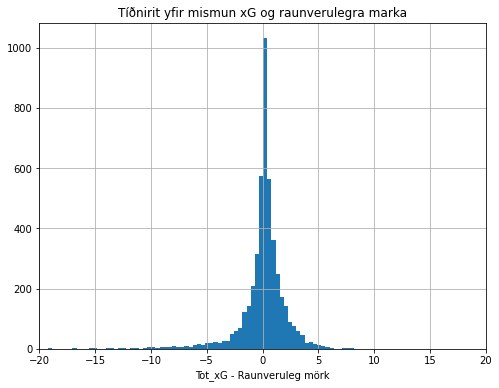

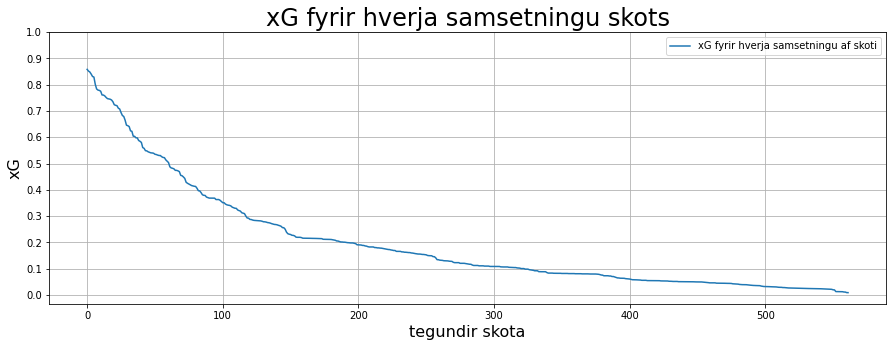

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


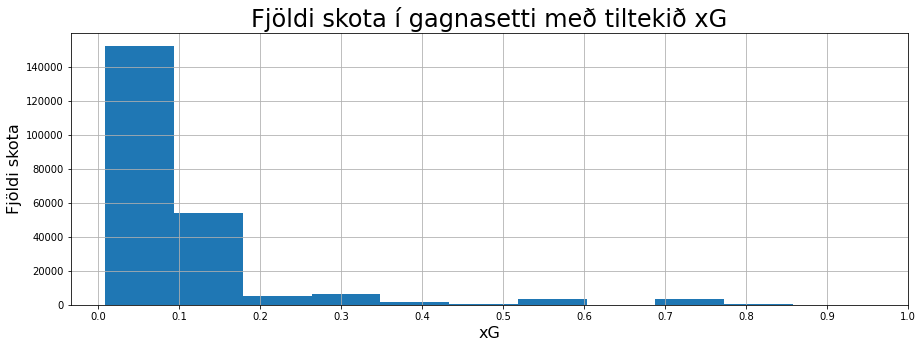

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


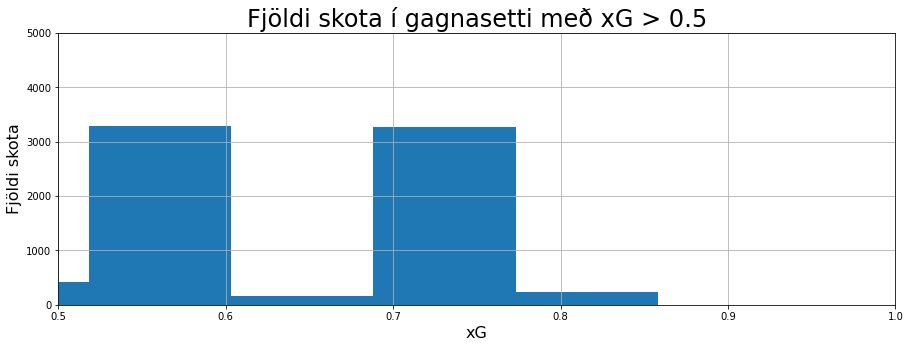

,0,1,2,3,4
fit_time,21.203802,22.554577,22.884503,20.676085,17.990097
score_time,0.175089,0.150465,0.176408,0.157430,0.148814
test_accuracy,0.913089,0.913554,0.911881,0.913305,0.913114
test_f1,0.325828,0.319172,0.303463,0.320309,0.329601
test_recall,0.216544,0.208922,0.197967,0.210615,0.220215
test_roc_auc,0.808650,0.805223,0.802421,0.799560,0.799074
test_precision,0.657804,0.675799,0.649676,0.668459,0.654912


In [58]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
train_and_evaluate(gbc, X_train_w_o_val,X_test,y_train_w_o_val,y_test,'GBC')

In [59]:
print(brier_score_loss(y_test, gbc.predict_proba(X_test)[:,1]))

0.07184824109353737


##KNeighborsClassifier



In [60]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
'''
#-------------------------------------------------------------------------------
#Leyta að bestu parametrum fyrir KNeighborsClassifier. Fékk að bestu parametrar
#væru 967 og 'distance' svo ég kommenta út search-ið og nota það framvegis.
#K
#-------------------------------------------------------------------------------

param_grid = {'n_neighbors' : [i for i in range(1,1000)],
              'weights' : ['uniform','distance'],
              }
rand_search_cv = RandomizedSearchCV(KNeighborsClassifier(),param_grid,cv = 3,
                                    scoring = ['accuracy', 'r2', 'f1', 'precision', 'roc_auc',]
                                    refit=False,
                                    n_iter = 10, verbose = 5)
rand_search_cv.fit(X_train,y_train)
results = pd.DataFrame(rand_search_cv.cv_results_)
show = results.sort_values(by='rank_test_accuracy', ascending=True)
show


KNC = KNeighborsClassifier(n_neighbors = 100, weights = 'distance') 
train_and_evaluate(KNC,X_train_w_o_val,X_test,y_train_w_o_val,y_test,'KNC')
'''

"\n#-------------------------------------------------------------------------------\n#Leyta að bestu parametrum fyrir KNeighborsClassifier. Fékk að bestu parametrar\n#væru 967 og 'distance' svo ég kommenta út search-ið og nota það framvegis.\n#K\n#-------------------------------------------------------------------------------\n\nparam_grid = {'n_neighbors' : [i for i in range(1,1000)],\n              'weights' : ['uniform','distance'],\n              }\nrand_search_cv = RandomizedSearchCV(KNeighborsClassifier(),param_grid,cv = 3,\n                                    scoring = ['accuracy', 'r2', 'f1', 'precision', 'roc_auc',]\n                                    refit=False,\n                                    n_iter = 10, verbose = 5)\nrand_search_cv.fit(X_train,y_train)\nresults = pd.DataFrame(rand_search_cv.cv_results_)\nshow = results.sort_values(by='rank_test_accuracy', ascending=True)\nshow\n\n\nKNC = KNeighborsClassifier(n_neighbors = 100, weights = 'distance') \ntrain_and_evalu

In [61]:
#print('Brier', brier_score_loss(y_test, KNC.predict_proba(X_test)[:,1]))

##Tauganet

###Föll

In [62]:
'''
def build_model(n_hidden=3,n_neurons=500, optimizer = 'adam',
                activation = 'relu', input_shape=[5]):
  model = keras.models.Sequential()
  model.add( keras.layers.InputLayer( input_shape = input_shape)) 
  for i in range(n_hidden):
    model.add(keras.layers.Dense(round(n_neurons/2**i), activation = activation)) 
  model.add(keras.layers.Dense(2,activation = 'softmax'))  
  model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = optimizer,
                metrics=["accuracy"]) 
  return model
  '''

'\ndef build_model(n_hidden=3,n_neurons=500, optimizer = \'adam\',\n                activation = \'relu\', input_shape=[5]):\n  model = keras.models.Sequential()\n  model.add( keras.layers.InputLayer( input_shape = input_shape)) \n  for i in range(n_hidden):\n    model.add(keras.layers.Dense(round(n_neurons/2**i), activation = activation)) \n  model.add(keras.layers.Dense(2,activation = \'softmax\'))  \n  model.compile(loss = "sparse_categorical_crossentropy",\n                optimizer = optimizer,\n                metrics=["accuracy"]) \n  return model\n  '

In [63]:
from scipy.stats import reciprocal
from keras.wrappers.scikit_learn import KerasClassifier
'''
NN_1 = KerasClassifier(build_model)
#history = NN_1.fit(X_train,y_train,
#                   epochs = 20,
#                   validation_data = (X_val,y_val))

param_grid = { "n_hidden": [i for i in range (5)], 
              "n_neurons": [100*i for i in range(1,11)], 
              "optimizer": ['sgd', 'adam', 'adamax', 'adagrad', 'nadam'],
              "activation" : ['relu', 'tanh', 'sigmoid']} 


early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10)    
cheakpoint_cb = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_2',
                                                save_best_only=True) 

rnd_search_cv = RandomizedSearchCV(NN_1, param_grid, n_iter = 10, verbose = 1, cv = 3,
                                   scoring = ['accuracy'],
                                   refit = False) 

history = rnd_search_cv.fit(X_train['scaled'], y_train,
                  epochs = 100,
                  batch_size = 32,
                  validation_data =(X_val['scaled'], y_val),
                  callbacks =[early_stopping_cb, cheakpoint_cb])

results = pd.DataFrame(rnd_search_cv.cv_results_)
show = results.sort_values(by='rank_test_accuracy', ascending=True)
show
'''


'\nNN_1 = KerasClassifier(build_model)\n#history = NN_1.fit(X_train,y_train,\n#                   epochs = 20,\n#                   validation_data = (X_val,y_val))\n\nparam_grid = { "n_hidden": [i for i in range (5)], \n              "n_neurons": [100*i for i in range(1,11)], \n              "optimizer": [\'sgd\', \'adam\', \'adamax\', \'adagrad\', \'nadam\'],\n              "activation" : [\'relu\', \'tanh\', \'sigmoid\']} \n\n\nearly_stopping_cb = keras.callbacks.EarlyStopping(patience = 10)    \ncheakpoint_cb = keras.callbacks.ModelCheckpoint(\n    \'/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_2\',\n                                                save_best_only=True) \n\nrnd_search_cv = RandomizedSearchCV(NN_1, param_grid, n_iter = 10, verbose = 1, cv = 3,\n                                   scoring = [\'accuracy\'],\n                                   refit = False) \n\nhistory = rnd_search_cv.fit(X_train[\'scaled\'], y_train,\n                  epo

In [64]:
'''
results = pd.DataFrame(rnd_search_cv.cv_results_)
show = results.sort_values(by='rank_test_accuracy', ascending=True)
show
'''

"\nresults = pd.DataFrame(rnd_search_cv.cv_results_)\nshow = results.sort_values(by='rank_test_accuracy', ascending=True)\nshow\n"

In [65]:
#NN_model.keras.models.save_model()
#NN_model = rnd_search_cv.best_estimator_.NN_model
#Show_Results(NN_model,X_test,y_test)
'''
NN_model = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_2'
    ) #roll back to best model

ypred = NN_model.predict(X_test['scaled'])
xG = ypred[:,1]
y_pred = np.argmax(ypred,axis=1)
Show_Results(NN_model, X_val['scaled'], y_test,y_pred,xG)

#Bætum nýja xG-inu í gagnasettið
shots['NN_2_xG'] = NN_model.predict(X['scaled']])[:,1]
shots['NN_2_mismunur'] = round(shots['NN_2_xG'] - shots['is_goal'],3)
shots.head(1)
'''

"\nNN_model = keras.models.load_model(\n    '/content/drive/MyDrive/Colab Notebooks/mynstursgr/Lokaverkefni/models/model_2'\n    ) #roll back to best model\n\nypred = NN_model.predict(X_test['scaled'])\nxG = ypred[:,1]\ny_pred = np.argmax(ypred,axis=1)\nShow_Results(NN_model, X_val['scaled'], y_test,y_pred,xG)\n\n#Bætum nýja xG-inu í gagnasettið\nshots['NN_2_xG'] = NN_model.predict(X['scaled']])[:,1]\nshots['NN_2_mismunur'] = round(shots['NN_2_xG'] - shots['is_goal'],3)\nshots.head(1)\n"

###Besti mismunur milli marka og xG 

### Greining á módeli útfrá leikmönnum

Við viljum að módelið sé u.þ.b. normaldreyft eftir leikmönnum. Þ.a. meðaltal mismuns marka og xG yfir alla leikmenn sé sem næst núlli og falli svo nokkuð jafnt til beggja átta.

Þ.e. viljum að meðal mismunur marka og xG fyrir leikmann sé 0 og meðal hlutfall marka og xG sé 1.

Einnig viljum við að samanlagt xG allra leikmanna og samanlögð mörk allra leikmanna sé sem næst hvort öðru. Það segir okkur að líkindin á mörkum séu að jafnast út til lengri tíma. Þ.e xG er ekki beint gott tól til að spá fyrir um hve mörg mörk í einum leik afþví þar spilar inn heppni, en yfir lengri tíma (7 ár í okkar tilfelli) ættu líkurnar að jafnast út.

Þetta er ágætis dreyfing. Langflestir leikmenn eru greinilega með eitthvað í kringum 0 í mismun milli xG og heildar marka. Þetta er hinsvegar töluvert þéttar hægra megin við 0 sem er ókostur.

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi atburða með yfir 0.9 í xG:   38
Fjöldi heildar atburða:             226677
Hlutfall atburða með yfir 0.9 í xG: 0.017 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


<Figure size 432x288 with 0 Axes>

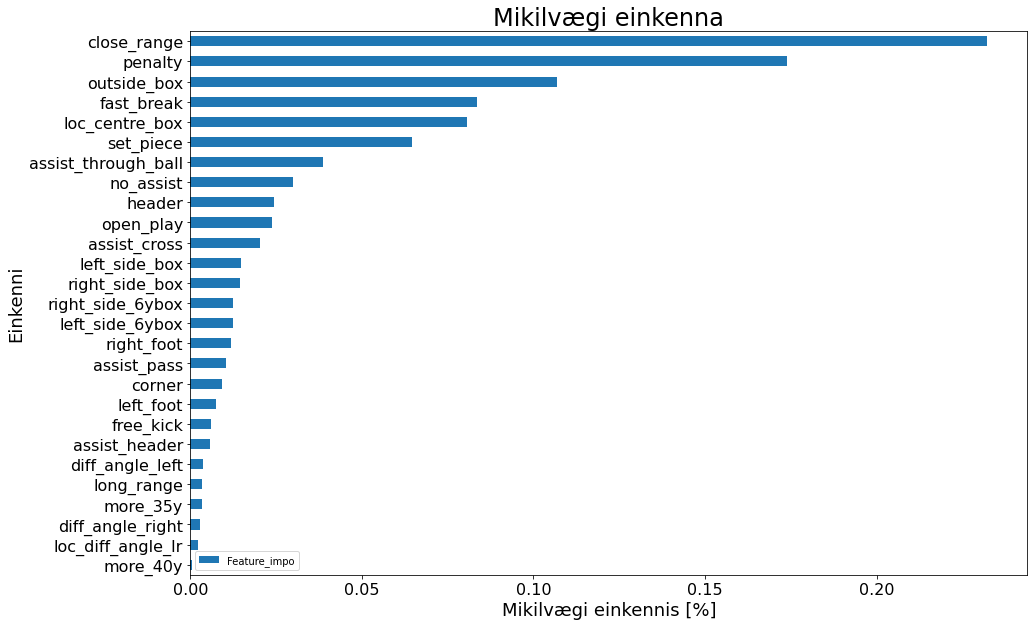

In [66]:
#-------------------------------------------------------------------------------
#Kíkjum nánar á Random forrest
#-------------------------------------------------------------------------------
very_high_xG_shots = shots[shots['RF_xG'] > 0.9]
printline()
print('Fjöldi atburða með yfir 0.9 í xG:  ',len(very_high_xG_shots))
print('Fjöldi heildar atburða:            ',len(shots))
print('Hlutfall atburða með yfir 0.9 í xG:',round(100*len(very_high_xG_shots)/len(shots),3),'%')
printline()


feature_impotrance = RandomForrest.feature_importances_
feature_impotrance = list(feature_impotrance) 
show = pd.DataFrame(feature_impotrance,
                    index = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick'])
show.columns = ['Feature_impo']
show = show.sort_values(by='Feature_impo')

plt.figure()
show.plot.barh(figsize=(15,10), fontsize = 16)
plt.title('Mikilvægi einkenna',fontsize=24)
plt.xlabel('Mikilvægi einkennis [%]',fontsize = 18)
plt.ylabel('Einkenni', fontsize = 18)
plt.show()

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi atburða með yfir 0.9 í xG:   125
Fjöldi heildar atburða:             226677
Hlutfall atburða með yfir 0.9 í xG: 0.055 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


<Figure size 432x288 with 0 Axes>

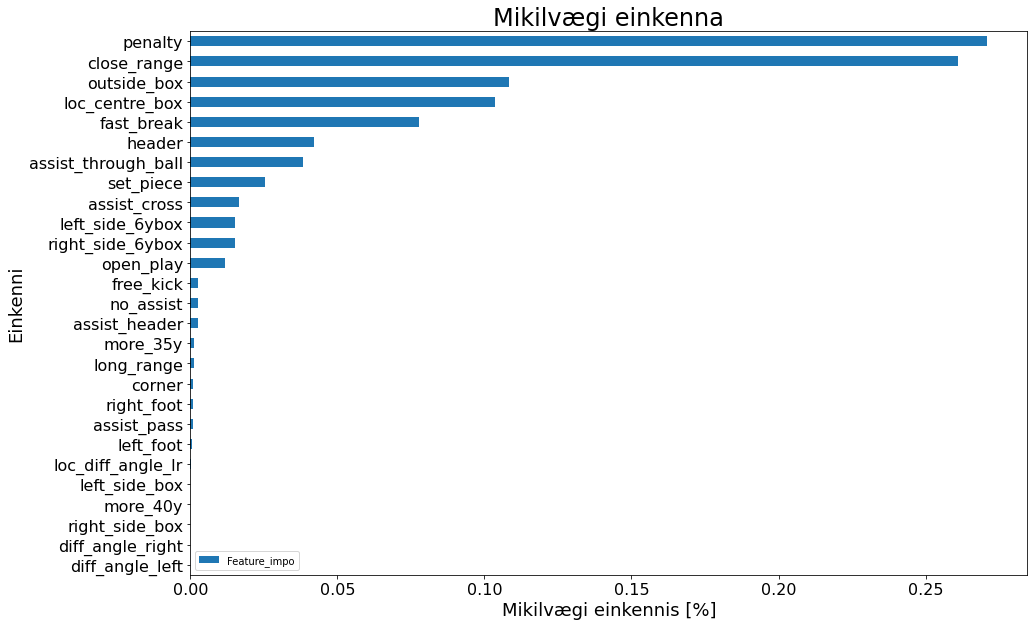

In [100]:
#-------------------------------------------------------------------------------
#Kíkjum nánar á Gradient boosting 
#-------------------------------------------------------------------------------
very_high_xG_shots = shots[shots['GBC_xG'] > 0.8]
printline()
print('Fjöldi atburða með yfir 0.9 í xG:  ',len(very_high_xG_shots))
print('Fjöldi heildar atburða:            ',len(shots))
print('Hlutfall atburða með yfir 0.9 í xG:',round(100*len(very_high_xG_shots)/len(shots),3),'%')
printline()


feature_impotrance = gbc.feature_importances_
feature_impotrance = list(feature_impotrance) 
show = pd.DataFrame(feature_impotrance,
                    index = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick'])
show.columns = ['Feature_impo']
show = show.sort_values(by='Feature_impo')

plt.figure()
show.plot.barh(figsize=(15,10), fontsize = 16)
plt.title('Mikilvægi einkenna',fontsize=24)
plt.xlabel('Mikilvægi einkennis [%]',fontsize = 18)
plt.ylabel('Einkenni', fontsize = 18)
plt.show()

In [68]:
#-------------------------------------------------------------------------------
#Log Reg hefur ekki feature importance en kíkjum á skot yfir 0.9
#-------------------------------------------------------------------------------
very_high_xG_shots = shots[shots['Log_Reg_xG'] > 0.9]
printline()
print('Fjöldi atburða með yfir 0.9 í xG:  ',len(very_high_xG_shots))
print('Fjöldi heildar atburða:            ',len(shots))
print('Hlutfall atburða með yfir 0.9 í xG:',round(100*len(very_high_xG_shots)/len(shots),3),'%')
printline()

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi atburða með yfir 0.9 í xG:   3
Fjöldi heildar atburða:             226677
Hlutfall atburða með yfir 0.9 í xG: 0.001 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [99]:
#-------------------------------------------------------------------------------
#Log Reg hefur ekki feature importance en kíkjum á skot yfir 0.9
#-------------------------------------------------------------------------------
very_high_xG_shots = shots[shots['NN_1_xG'] > 0.78]
printline()
print('Fjöldi atburða með yfir 0.9 í xG:  ',len(very_high_xG_shots))
print('Fjöldi heildar atburða:            ',len(shots))
print('Hlutfall atburða með yfir 0.9 í xG:',round(100*len(very_high_xG_shots)/len(shots),3),'%')
printline()

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Fjöldi atburða með yfir 0.9 í xG:   0
Fjöldi heildar atburða:             226677
Hlutfall atburða með yfir 0.9 í xG: 0.0 %
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [103]:
#-------------------------------------------------------------------------------
#Vítapróf
#-------------------------------------------------------------------------------
pen_l_foot = [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	0,	0,	0,	0,	0,	1,	0,	1,	0,	0,	0,	0,	0,	1,	0,	0]
pen_r_foot = [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	0,	0,	0,	0,	1,	0,	0,	1,	0,	0,	0,	0,	0,	1,	0,	0]
print('Log Reg:           ',Log_Reg_Model.predict_proba([pen_l_foot])[:,1][0])
print('Random Forrest:    ',RandomForrest.predict_proba([pen_l_foot])[:,1][0])
print('Tauganet:          ',model_1.predict([pen_l_foot])[:,1][0])
print('Gradient Boosting: ',gbc.predict_proba([pen_l_foot])[:,1][0])

Log Reg:            0.7513148645279784
Random Forrest:     0.780331042275807
Tauganet:           0.7630097
Gradient Boosting:  0.7571025362944964


In [71]:
DisplayByFeature('RF','_hlutfall',5,goals_over=20)

,player,total_goals,RF_xG,RF_mismunur,RF_hlutfall
0,Franck Ribery,38,19.258485,-18.777,1.973
1,Blerim Dzemaili,22,12.102458,-9.934,1.818
2,James Rodriguez,22,12.175528,-9.822,1.807
3,Gregoire Defrel,22,12.276421,-9.731,1.792
4,Iago Falque,25,14.179335,-10.821,1.763


In [72]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model_1.predict(X_test)[:, 1]))
print(roc_auc_score(y_test, Log_Reg_Model.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, RandomForrest.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1]))
#print(roc_auc_score(y_test, KNC.predict_proba(X_test)[:, 1]))

0.8009949003349519
0.7990695068403022
0.7998727159289377
0.7986957873881098


##Lið

In [73]:
#cols = ['event_team','is_goal', 'Log_Reg_xG', 'Log_Reg_mismunur', 'RF_xG', 'RF_mismunur','NN_1_xG', 'NN_1_mismunur']
teams = shots.groupby('event_team').sum().reset_index()
teams.rename(columns= {'is_goal' : 'Heildar_Mörk'},inplace=True)
teams['Log_Reg_hlutfall'] = round(teams['Heildar_Mörk'] / teams['Log_Reg_xG'],3)
teams['RF_hlutfall'] = round(teams['Heildar_Mörk'] / teams['RF_xG'],3)
teams['NN_1_hlutfall'] = round(teams['Heildar_Mörk'] / teams['NN_1_xG'],3)
teams.iloc[:5]

,event_team,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,Heildar_Mörk,location,bodypart,assist_method,situation,fast_break,season,Log_Reg_xG,Log_Reg_mismunur,RF_xG,RF_mismunur,NN_1_xG,NN_1_mismunur,GBC_xG,GBC_mismunur,Log_Reg_hlutfall,RF_hlutfall,NN_1_hlutfall
0,Ac Ajaccio,60936,54352,1093,9096.0,1544,6453,2112,101,11298,1796,1127,1410,12,2200209,102.204576,1.241,101.423999,0.347,100.344177,-0.735999,102.909194,1.880,0.988,0.996,1.007
1,Ac Milan,164026,146552,3025,26232.0,4347,16833,5929,289,32760,4485,3097,3826,53,6092972,286.854282,-2.025,286.855942,-2.475,284.551605,-4.788999,285.693603,-3.378,1.007,1.007,1.016
2,Aj Auxerre,23250,22024,442,3600.0,621,2652,840,42,4541,754,482,603,16,889304,43.168786,1.176,42.991845,0.959,42.692410,0.661000,43.438829,1.435,0.973,0.977,0.984
3,Alaves,8495,7785,168,1476.0,244,1068,319,17,1507,298,194,228,3,338856,15.853996,-1.143,15.670439,-1.333,15.553231,-1.460000,15.997802,-1.008,1.072,1.085,1.093
4,Almeria,39602,36324,757,6408.0,1091,4324,1463,67,7938,1218,802,993,22,1524963,74.349793,7.373,74.508550,7.442,74.211899,7.139000,75.032969,8.028,0.901,0.899,0.903


###Mesta xG á lið

In [74]:
show = teams.sort_values('RF_xG', ascending=False)
show = show[['Heildar_Mörk', 'Log_Reg_xG',	'Log_Reg_mismunur',
             'RF_xG',	'RF_mismunur',	'NN_1_xG',	'NN_1_mismunur',
             'GBC_xG',	'GBC_mismunur',	'Log_Reg_hlutfall',	'RF_hlutfall',
             'NN_1_hlutfall']]
show.head(5)

,Heildar_Mörk,Log_Reg_xG,Log_Reg_mismunur,RF_xG,RF_mismunur,NN_1_xG,NN_1_mismunur,GBC_xG,GBC_mismunur,Log_Reg_hlutfall,RF_hlutfall,NN_1_hlutfall
103,525,407.413822,-117.493,405.995286,-119.332,402.721527,-122.701996,403.111414,-121.898,1.289,1.293,1.304
14,534,402.294149,-131.638,402.720201,-131.560,401.130096,-133.186996,396.710618,-137.338,1.327,1.326,1.331
96,398,356.085397,-41.862,355.026386,-43.202,352.167664,-46.119999,351.476639,-46.560,1.118,1.121,1.130
64,361,338.617792,-22.247,336.952165,-24.425,336.422150,-25.023998,337.185836,-23.871,1.066,1.071,1.073
88,379,326.994586,-51.936,329.186009,-50.152,326.701385,-52.674000,325.629325,-53.428,1.159,1.151,1.160


###Man Utd

In [75]:
teams[teams.event_team == 'Manchester Utd']

,event_team,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,Heildar_Mörk,location,bodypart,assist_method,situation,fast_break,season,Log_Reg_xG,Log_Reg_mismunur,RF_xG,RF_mismunur,NN_1_xG,NN_1_mismunur,GBC_xG,GBC_mismunur,Log_Reg_hlutfall,RF_hlutfall,NN_1_hlutfall
82,Manchester Utd,78555,85474,1737,15480.0,2486,9683,3440,187,16933,2804,1944,2131,11,3500793,173.491656,-13.458,173.796451,-13.36,172.258499,-14.916999,172.917959,-14.105,1.078,1.076,1.086


In [76]:
manutd = shots[shots.event_team == 'Manchester Utd']
manutd_players = manutd.groupby('player').sum().reset_index()
manutd_players.rename(columns= {'is_goal' : 'Mörk'},inplace=True)
manutd_players[['player','Mörk','Log_Reg_xG',	'Log_Reg_mismunur',	'RF_xG',	'RF_mismunur',	'NN_1_xG',	'NN_1_mismunur']].sort_values(['RF_xG'],ascending=False).iloc[:-1].reset_index(drop=True)

,player,Mörk,Log_Reg_xG,Log_Reg_mismunur,RF_xG,RF_mismunur,NN_1_xG,NN_1_mismunur
0,Wayne Rooney,35,27.170500,-7.808,27.406759,-7.634,27.213511,-7.829
1,Robin Van Persie,19,16.984666,-2.019,17.094609,-1.906,16.860754,-2.151
2,Juan Mata,21,15.887425,-5.106,15.737685,-5.267,15.688887,-5.312
3,Marouane Fellaini,7,10.047286,3.054,10.182204,3.177,10.136019,3.127
4,Zlatan Ibrahimovic,14,10.220375,-3.777,9.997877,-4.011,9.912193,-4.096
5,Chris Smalling,6,6.714453,0.715,6.821527,0.821,6.714016,0.711
6,Anthony Martial,13,6.219875,-6.781,6.228848,-6.778,6.067598,-6.939
7,Ander Herrera,8,6.194317,-1.799,6.188402,-1.827,6.139159,-1.877
8,Jesse Lingard,4,5.460242,1.464,5.565834,1.555,5.414471,1.404
9,Falcao,4,5.569693,1.572,5.548499,1.547,5.599895,1.595


##Ronaldo

Heildar Mörk

In [77]:
Ronaldo = shots[(shots.player == 'Cristiano Ronaldo')][['season', 'is_goal', 'NN_1_xG' , 'NN_1_mismunur']].groupby('season').sum().reset_index()
Ronaldo['Hlutfall'] = Ronaldo['is_goal'] / Ronaldo['NN_1_xG']
Ronaldo.columns = ['Leiktíð' , 'Mörk', 'xG', 'Mismunur', 'Hlutfall'] 
Ronaldo.iloc[:-1]

,Leiktíð,Mörk,xG,Mismunur,Hlutfall
0,2012,39,29.155153,-9.865,1.337671
1,2013,28,24.646847,-3.383,1.136048
2,2014,27,23.639526,-3.387,1.142155
3,2015,40,26.571426,-13.448,1.505376
4,2016,30,26.570606,-3.457,1.129067


Mörk með skalla

In [78]:
Ronaldo = shots[(shots.player == 'Cristiano Ronaldo') & (shots.bodypart == 3)][['season', 'is_goal', 'RF_xG' , 'RF_mismunur']].groupby('season').sum().reset_index()
Ronaldo['ratio'] = Ronaldo['is_goal'] / Ronaldo['RF_xG'] 
Ronaldo

,season,is_goal,RF_xG,RF_mismunur,ratio
0,2012,7,3.723474,-3.277,1.879965
1,2013,6,3.001997,-2.997,1.998670
2,2014,3,2.827537,-0.171,1.060994
3,2015,12,3.860148,-8.137,3.108689
4,2016,5,3.323385,-1.673,1.504490
5,2017,2,2.073219,0.073,0.964683


##Greiningar

###leikmannagreiningar

###Besta hlutfall leikmanna með 20+ mörk

In [79]:
DisplayByFeature(model='NN_1',feature_inp='_hlutfall',nr=5,goals_over=20)

,player,total_goals,NN_1_xG,NN_1_mismunur,NN_1_hlutfall
0,Franck Ribery,38,19.192509,-18.827999,1.980
1,Blerim Dzemaili,22,11.823383,-10.203000,1.861
2,Gregoire Defrel,22,12.096637,-9.912000,1.819
3,James Rodriguez,22,12.268190,-9.731999,1.793
4,Iago Falque,25,14.101942,-10.907000,1.773


###Besta hlutfall leikmanna með 30+ mörk

In [80]:
DisplayByFeature(model='NN_1',feature_inp='_hlutfall',nr=5,goals_over=30)

,player,total_goals,NN_1_xG,NN_1_mismunur,NN_1_hlutfall
0,Franck Ribery,38,19.192509,-18.827999,1.980
1,Heungmin Son,32,19.804245,-12.219000,1.616
2,Mario Gotze,35,21.879812,-13.145000,1.600
3,Luis Suarez,90,57.419712,-32.618999,1.567
4,Carlos Tevez,37,23.948025,-13.087999,1.545


###Besta hlutfall leikmanna með 50+ mörk

In [81]:
DisplayByFeature(model='NN_1',feature_inp='_hlutfall',nr=5,goals_over=50)

,player,total_goals,NN_1_xG,NN_1_mismunur,NN_1_hlutfall
0,Luis Suarez,90,57.419712,-32.618999,1.567
1,Eden Hazard,60,39.910461,-20.132000,1.503
2,Lionel Messi,186,125.386108,-60.659000,1.483
3,Alexis Sanchez,72,49.687473,-22.368000,1.449
4,Alexandre Lacazette,82,58.080059,-23.971001,1.412


###Hæsta xG

In [107]:
DisplayByFeature(model='NN_1',feature_inp='_hlutfall',nr=10,goals_over=20).to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n{} &           player &  total\\_goals &    NN\\_1\\_xG &  NN\\_1\\_mismunur &  NN\\_1\\_hlutfall \\\\\n\\midrule\n0 &  Franck Ribery &  38 &  19.192509 & -18.827999 &  1.980 \\\\\n1 &  Blerim Dzemaili &  22 &  11.823383 & -10.203000 &  1.861 \\\\\n2 &  Gregoire Defrel &  22 &  12.096637 & -9.912000 &  1.819 \\\\\n3 &  James Rodriguez &  22 &  12.268190 & -9.731999 &  1.793 \\\\\n4 &  Iago Falque &  25 &  14.101942 & -10.907000 &  1.773 \\\\\n5 &  Nabil Fekir &  22 &  12.543976 & -9.459000 &  1.754 \\\\\n6 &  Josip Drmic &  23 &  13.376390 & -9.633000 &  1.719 \\\\\n7 &  Dele Alli &  21 &  12.622564 & -8.399000 &  1.664 \\\\\n8 &  Mohamed Salah &  28 &  17.056576 & -10.959000 &  1.642 \\\\\n9 &  Younes Belhanda &  21 &  12.838589 & -8.189000 &  1.636 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [83]:
DisplayByFeature(model='Log_Reg',feature_inp='_xG',nr=10)

,player,total_goals,Log_Reg_xG,Log_Reg_mismunur,Log_Reg_hlutfall
0,Cristiano Ronaldo,175,145.203176,-29.760,1.205
1,Lionel Messi,186,126.289580,-59.707,1.473
2,Zlatan Ibrahimovic,139,106.745570,-32.226,1.302
3,Edinson Cavani,115,106.691367,-8.286,1.078
4,Robert Lewandowski,115,90.621009,-24.343,1.269
5,Gonzalo Higuain,115,81.236625,-33.742,1.416
6,Pierreemerick Aubameyang,87,79.878686,-7.130,1.089
7,Diego Costa,91,68.629014,-22.358,1.326
8,Antonio Di Natale,67,66.003256,-0.989,1.015
9,Bafetimbi Gomis,64,63.191419,-0.804,1.013


In [84]:
DisplayByFeature(model='RF',feature_inp='_xG',nr=10)

,player,total_goals,RF_xG,RF_mismunur,RF_hlutfall
0,Cristiano Ronaldo,175,143.614082,-31.521,1.219
1,Lionel Messi,186,126.411903,-59.638,1.471
2,Zlatan Ibrahimovic,139,106.729380,-32.339,1.302
3,Edinson Cavani,115,106.520739,-8.515,1.080
4,Robert Lewandowski,115,89.477077,-25.570,1.285
5,Gonzalo Higuain,115,81.931217,-33.118,1.404
6,Pierreemerick Aubameyang,87,79.590130,-7.470,1.093
7,Diego Costa,91,69.608218,-21.417,1.307
8,Antonio Di Natale,67,66.339175,-0.717,1.010
9,Bafetimbi Gomis,64,63.507629,-0.534,1.008


###Mesti mismunur

In [85]:
DisplayByFeature(model='NN_1',feature_inp='_mismunur',nr=10)

,player,total_goals,NN_1_xG,NN_1_mismunur,NN_1_hlutfall
0,Lionel Messi,186,125.386108,-60.659000,1.483
1,Zlatan Ibrahimovic,139,105.531471,-33.530998,1.317
2,Gonzalo Higuain,115,81.692825,-33.403000,1.408
3,Luis Suarez,90,57.419712,-32.618999,1.567
4,Cristiano Ronaldo,175,142.850601,-32.284000,1.225
5,Robert Lewandowski,115,88.865028,-26.222000,1.294
6,Alexandre Lacazette,82,58.080059,-23.971001,1.412
7,Karim Benzema,84,60.742558,-23.320000,1.383
8,Alexis Sanchez,72,49.687473,-22.368000,1.449
9,Diego Costa,91,69.326225,-21.726999,1.313


In [86]:
DisplayByFeature(model='Log_Reg',feature_inp='_mismunur',nr=10)

,player,total_goals,Log_Reg_xG,Log_Reg_mismunur,Log_Reg_hlutfall
0,Lionel Messi,186,126.289580,-59.707,1.473
1,Gonzalo Higuain,115,81.236625,-33.742,1.416
2,Luis Suarez,90,57.134095,-32.858,1.575
3,Zlatan Ibrahimovic,139,106.745570,-32.226,1.302
4,Cristiano Ronaldo,175,145.203176,-29.760,1.205
5,Robert Lewandowski,115,90.621009,-24.343,1.269
6,Alexandre Lacazette,82,58.469790,-23.513,1.402
7,Karim Benzema,84,61.558347,-22.438,1.365
8,Diego Costa,91,68.629014,-22.358,1.326
9,Alexis Sanchez,72,49.862457,-22.119,1.444


In [87]:
DisplayByFeature(model='RF',feature_inp='_mismunur',nr=10)

,player,total_goals,RF_xG,RF_mismunur,RF_hlutfall
0,Lionel Messi,186,126.411903,-59.638,1.471
1,Gonzalo Higuain,115,81.931217,-33.118,1.404
2,Luis Suarez,90,56.927541,-33.111,1.581
3,Zlatan Ibrahimovic,139,106.729380,-32.339,1.302
4,Cristiano Ronaldo,175,143.614082,-31.521,1.219
5,Robert Lewandowski,115,89.477077,-25.570,1.285
6,Karim Benzema,84,60.404581,-23.632,1.391
7,Alexandre Lacazette,82,58.606608,-23.434,1.399
8,Alexis Sanchez,72,50.278056,-21.774,1.432
9,Diego Costa,91,69.608218,-21.417,1.307


###Versti mismunur

In [88]:
DisplayByFeature(model='NN_1',feature_inp='_mismunur',nr=5000).tail(10)

,player,total_goals,NN_1_xG,NN_1_mismunur,NN_1_hlutfall
4714,Martin Braithwaite,26,33.563171,7.531,0.775
4715,Riccardo Meggiorini,14,21.574450,7.555,0.649
4716,Roberto Trashorras,3,10.610705,7.593,0.283
4717,Diego Godin,10,17.659124,7.650,0.566
4718,Giampaolo Pazzini,28,35.685516,7.657,0.785
4719,Bostjan Cesar,2,9.688333,7.686,0.206
4720,Adrian Mutu,14,22.221714,8.200,0.630
4721,Mats Hummels,8,16.503195,8.495,0.485
4722,Amauri,20,30.466640,10.438,0.656
4723,Jesus Navas,9,22.733370,13.704,0.396


In [89]:
DisplayByFeature(model='Log_Reg',feature_inp='_mismunur',nr=5000).tail(10)

,player,total_goals,Log_Reg_xG,Log_Reg_mismunur,Log_Reg_hlutfall
4714,Mario Balotelli,29,36.702176,7.722,0.790
4715,Giampaolo Pazzini,28,35.831500,7.837,0.781
4716,Diego Godin,10,17.836515,7.842,0.561
4717,Martin Braithwaite,26,33.912411,7.917,0.767
4718,Roberto Trashorras,3,10.911308,7.923,0.275
4719,Bostjan Cesar,2,9.975319,7.976,0.200
4720,Adrian Mutu,14,22.138198,8.149,0.632
4721,Mats Hummels,8,16.847089,8.853,0.475
4722,Amauri,20,30.709946,10.719,0.651
4723,Jesus Navas,9,22.709522,13.706,0.396


In [90]:
DisplayByFeature(model='RF',feature_inp='_mismunur',nr=5000).tail(10)

,player,total_goals,RF_xG,RF_mismunur,RF_hlutfall
4714,Mario Balotelli,29,36.588869,7.527,0.793
4715,Roberto Trashorras,3,10.677945,7.646,0.281
4716,Martin Braithwaite,26,33.781267,7.757,0.770
4717,Diego Godin,10,17.790351,7.793,0.562
4718,Bostjan Cesar,2,9.800384,7.798,0.204
4719,Giampaolo Pazzini,28,35.834531,7.825,0.781
4720,Mats Hummels,8,16.598648,8.591,0.482
4721,Adrian Mutu,14,22.768334,8.747,0.615
4722,Amauri,20,30.511879,10.504,0.655
4723,Jesus Navas,9,22.814855,13.776,0.394


###Bestu skotin

In [91]:
show = shots

In [92]:
shots.to_csv('shots.csv')
players.to_csv('players.csv')

In [93]:
from google.colab import files
files.download("shots.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
files.download("players.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
!echo "# mynstursgreining" >> README.md

In [110]:
!git init

Initialized empty Git repository in /content/.git/


In [115]:
!echo "# mynstursgreining" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/reynire99/mynstursgreining.git
!git push -u origin main

Reinitialized existing Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@749e222fabff.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed
fatal: remote origin already exists.
error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/reynire99/mynstursgreining.git'
